<a href="https://colab.research.google.com/github/MMW1999/TGO-LR-and-DT-for-detecting-the-EZ/blob/main/Syncope_arrythmia_notebook_OLVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### Installing required packages

In [ ]:
!pip install ecg-plot
!pip install tensorflow-addons
!pip install wfdb
!pip install iterative-stratification
!pip install keras-tuner
!pip install graphviz
!pip install hyperopt
!pip install scikit-plot

# Connecting to Google Drive and Github repository

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!git status
#!git add
#!git commit -m
#!git push

In [ ]:
import numpy as np
import pandas as pd
import h5py
import scipy
import sklearn
import tqdm
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
import pydot
import openpyxl
import argparse
import os
import math
import ecg_plot

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import kerastuner as kt
import keras.backend as K
from kerastuner import HyperParameters
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import (Sequence,
                                    plot_model)
from tensorflow.keras.layers import (Input,
                                     Conv1D,
                                     MaxPooling1D,
                                     Dropout,
                                     BatchNormalization,
                                     Activation,
                                     Add,
                                     Flatten,
                                     Dense)
from tensorflow.keras.models import (load_model,
                                     Model)
from tensorflow.keras.metrics import (BinaryAccuracy,
                                      Recall,
                                      Precision,
                                      AUC,
                                      F1Score)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint,
                                        TensorBoard,
                                        ReduceLROnPlateau,
                                        CSVLogger,
                                        EarlyStopping,
                                        Callback)
#from scikitplot.metrics import plot_confusion_matrix, plot_roc
from hyperopt import hp

import sklearn
from scipy import optimize
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import IterativeStratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.metrics import (confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score,
                             classification_report,
                             roc_curve,
                             auc)
from scikitplot.metrics import (plot_confusion_matrix, plot_roc)

import helper_functions as hf
import model

from typing import Tuple

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload
%reload_ext autoreload

# Setting seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(33)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data exploration

In [ ]:
#!wget -r -N -c -np https://physionet.org/files/ecg-arrhythmia/1.0.0/

In [ ]:
!unzip -q '/content/drive/MyDrive/Python_Syncope/ChapmanNingbo_dataset.zip' -d '/content/'

plotting ECG fragment as example

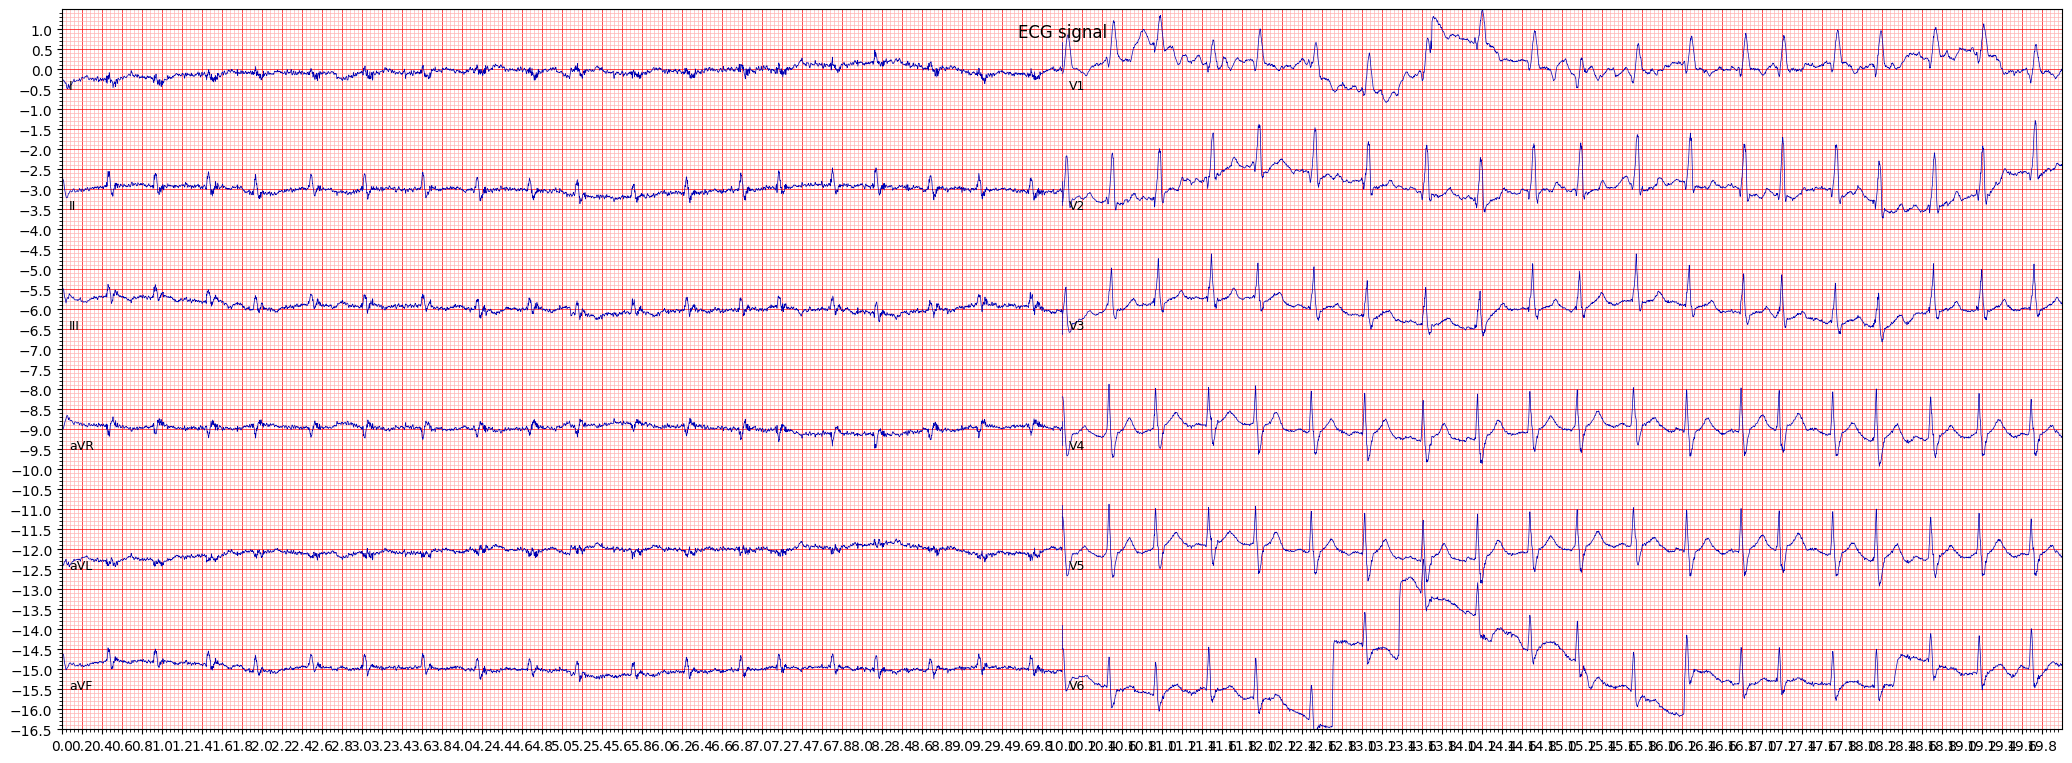

In [ ]:
hf.plot_ecg(r"/content/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/01/010/JS00001.mat", 500, 'ECG signal')


In [ ]:
gender, age, labels, ecg_filenames = hf.import_key_data(r"/content/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0")
ecg_filenames = np.asarray(ecg_filenames)

In [ ]:
age, gender = hf.import_gender_and_age(age, gender)

mean_age = np.mean(age)
std_age = np.std(age)

total_count = len(gender)
female_count = sum(gender == 'female')
fraction_female = female_count / total_count

gender data shape: 45152
age data shape: 45152


## Multilabel classification problem

### SNOMED-CT mapping to diagnoses

In [ ]:
split_labels_list = [labels.split(",") for labels in labels]
flattened_labels = [label for sublist in split_labels_list for label in sublist]
unique_labels_dataset = np.unique(flattened_labels)

del split_labels_list, flattened_labels

In [ ]:
# Loading SNOMED CT codes for classification
classification_labels_SNOMED_CT=pd.read_csv(r"/content/drive/MyDrive/Python_Syncope/SNOMED_Codes_classification.csv", sep=";")

# Loading SNOMED CT mapping files
SNOMED_scored=pd.read_csv(r"/content/drive/MyDrive/Python_Syncope/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv(r"/content/drive/MyDrive/Python_Syncope/SNOMED_mappings_unscored.csv", sep=";")

SNOMED=pd.read_csv(r"//content/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/ConditionNames_SNOMED-CT.csv", sep=",")
column_mapping = {
    'Acronym Name': 'Abbreviation',
    'Full Name': 'Dx',
    'Snomed_CT': 'SNOMED CT Code'
    }
SNOMED = SNOMED.rename(columns=column_mapping)
SNOMED = SNOMED[['Dx', 'SNOMED CT Code', 'Abbreviation']]

# Creating variable contains all SNOMED codes mappings
SNOMEDmappings = pd.concat([SNOMED_scored.iloc[:, :3],
                            SNOMED_unscored.iloc[:, :3],
                            SNOMED.iloc[:, :3]],
                           ignore_index=True
                           )  # 174 SNOMED mappings
SNOMEDmappings = SNOMEDmappings.drop_duplicates(subset=['SNOMED CT Code'])
SNOMEDmappings.reset_index(drop=True, inplace=True)

unique_labels_set = set(unique_labels_dataset)
SNOMEDmappings['SNOMED CT Code'] = SNOMEDmappings['SNOMED CT Code'].astype(str)
# keeping only the mappings for the label in the dataset
SNOMEDmappings = SNOMEDmappings[SNOMEDmappings['SNOMED CT Code'].isin(unique_labels_set)]

del SNOMED_scored, SNOMED_unscored, SNOMED, column_mapping, unique_labels_set

SNOMEDmappings['SNOMED CT Code'] = SNOMEDmappings['SNOMED CT Code'].astype(str)
classification_labels_SNOMED_CT['SNOMED CT Code'] = classification_labels_SNOMED_CT['SNOMED CT Code'].astype(str)
# Merge SNOMEDmappings with classification_labels_SNOMED_CT using the 'SNOMED CT Code' column
merged_df = pd.merge(SNOMEDmappings, classification_labels_SNOMED_CT, how='left', indicator=True)

not_in_classification_SNOMEDmappings = merged_df[merged_df['_merge'] == 'left_only'][SNOMEDmappings.columns]                    # 26 SNOMED codes not part of classification

# df_labels contains all SNOMED-CT labels of the labesls the model will be trained upon
# and sets labels the model wont be trained upon to undefined
df_labels = hf.make_undefined_class(labels, not_in_classification_SNOMEDmappings)

### One-hot encode labels

In [ ]:
df_labels.columns =range(df_labels.shape[1])
y , snomed_classes = hf.MLB_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111288001' '111975006' '164865005' '164873001' '164889003'
 '164890007' '164896001' '164909002' '164917005' '164931005' '164934002'
 '164947007' '17338001' '195042002' '233917008' '251120003' '251146004'
 '270492004' '27885002' '29320008' '39732003' '425856008' '426177001'
 '426627000' '426648003' '426761007' '426783006' '426995002' '427084000'
 '427393009' '445118002' '445211001' '47665007' '49578007' '54016002'
 '54329005' '57054005' '59118001' '59931005' '63593006' '6374002'
 '65778007' '698252002' '713422000' '713426002' '74390002' '77867006'
 'Unknown' 'undefined class']
classes: 48


In [ ]:
snomed_abbr = []

for j in range(len(snomed_classes)):
    for i in range(len(classification_labels_SNOMED_CT.iloc[:,1])):
        # if the SNOMED-CT code matches the code in SNOMED_CT classification variable
        # then the corresponding abbreviation is appended into snomed_abbr
        if (str(classification_labels_SNOMED_CT.iloc[:,1][i]) == snomed_classes[j]):
            snomed_abbr.append(classification_labels_SNOMED_CT.iloc[:,2][i])

snomed_abbr = np.asarray(snomed_abbr)

del i, j

### Distribution of labels accross dataset
The generated figure gives an overview of the distribution of arrhytmias in the dataset. The frequency of a diagnoses can be seen on the y axis and the diagnosis is displayed on the x-axis.
A skewed distribution can lead to a bias in the ResNet model and therefore prevention measures should be taken to prevent this.

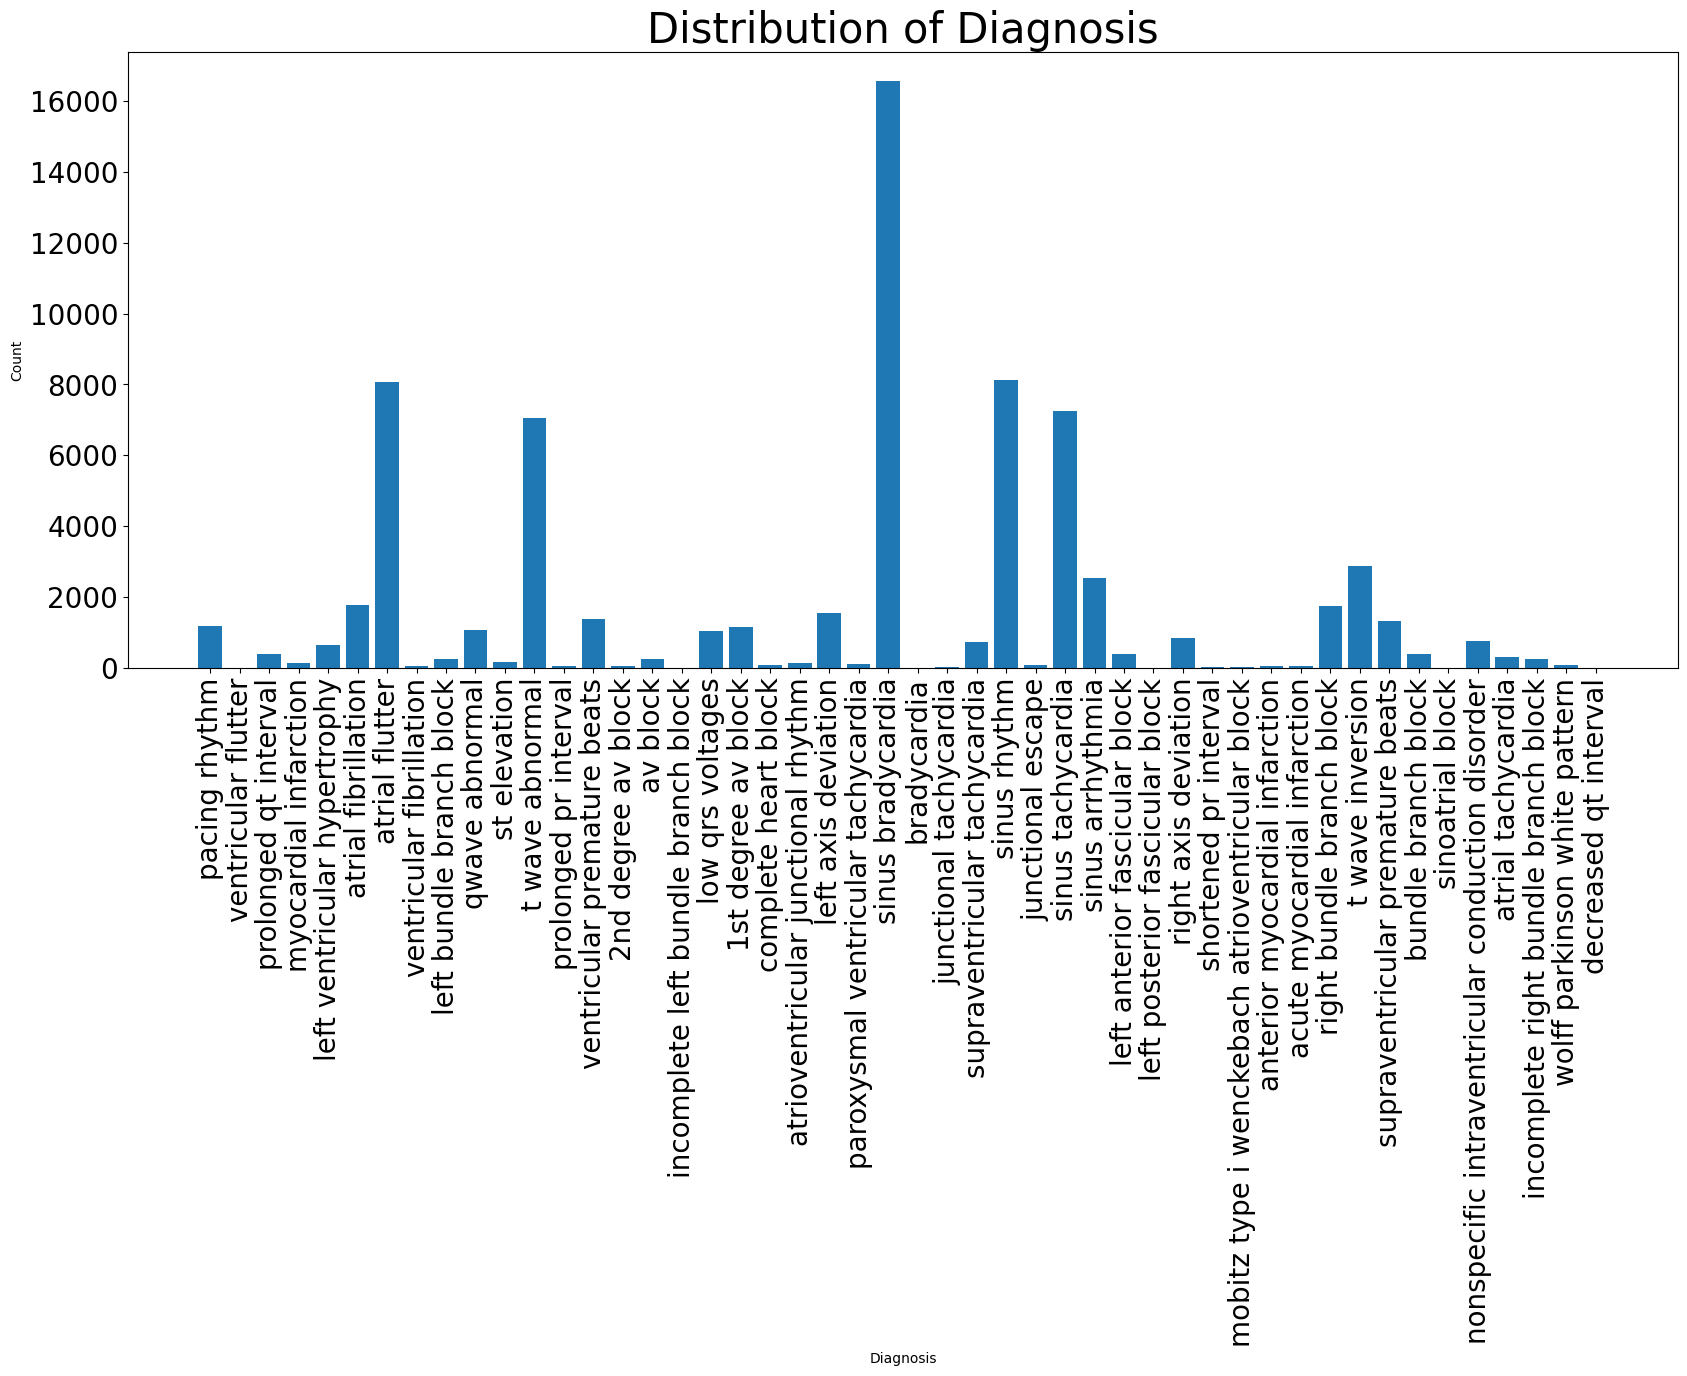

In [ ]:
hf.plot_classes(snomed_classes, classification_labels_SNOMED_CT, y)

Checking dataset for combination of diagnosed arrhytmias for an ECG signal entry

In [ ]:
y_all_comb = hf.get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

Total number of unique combinations of diagnosis: 2155


# Deviding dataset in a train and test set

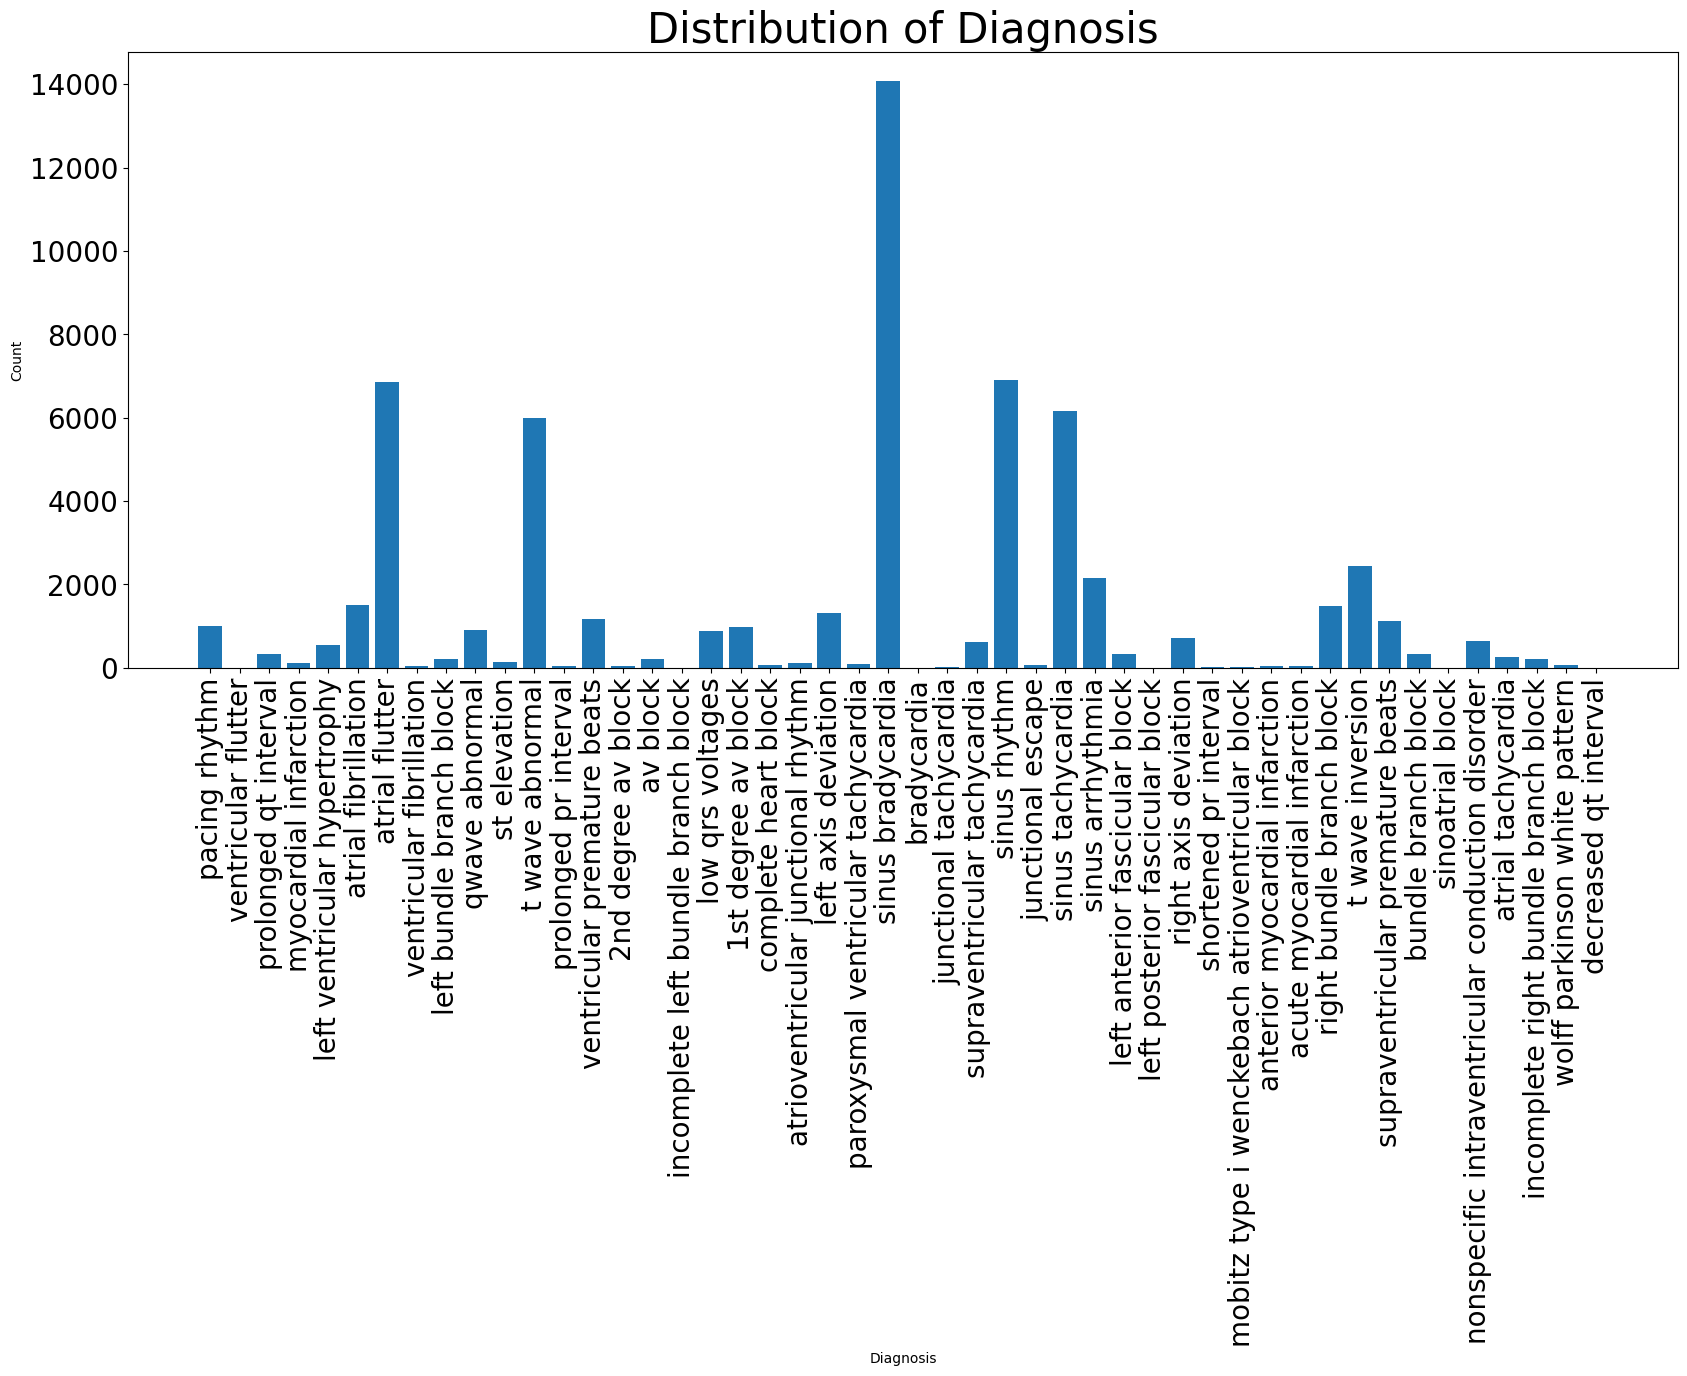

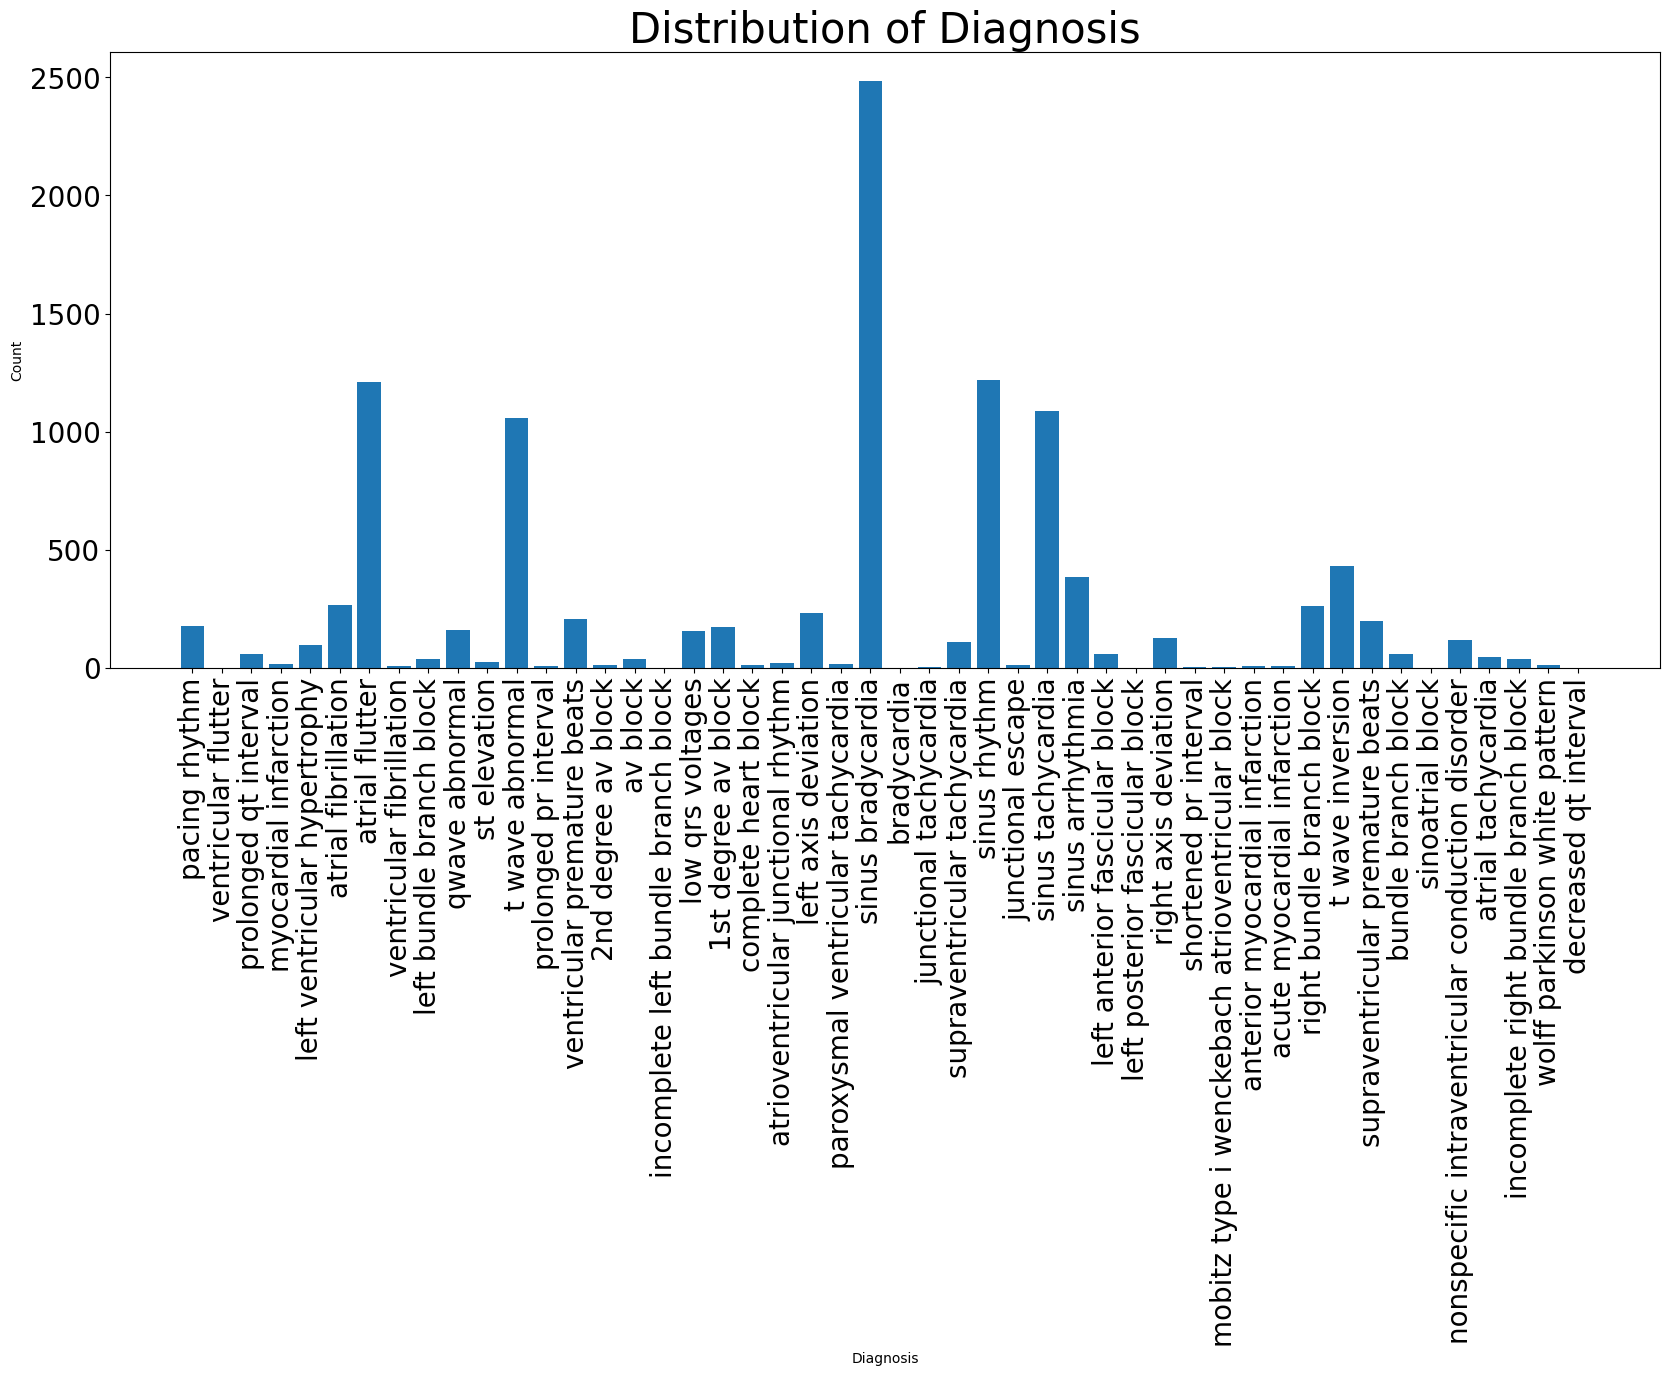

In [ ]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=33)

for train_index, test_index in msss.split(ecg_filenames, y):
   #print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = ecg_filenames[train_index], ecg_filenames[test_index]
   y_train, y_test = y[train_index], y[test_index]

hf.plot_classes(snomed_classes, classification_labels_SNOMED_CT, y_train)
hf.plot_classes(snomed_classes, classification_labels_SNOMED_CT, y_test)

In [ ]:
y_train_all_comb = hf.get_labels_for_all_combinations(y[train_index])
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_train_all_comb))))

Total number of unique combinations of diagnosis: 1950


## Generate folds from trainingdataset for training

In [ ]:
labels_train = [labels[i] for i in train_index]
folds_train = hf.split_data(labels_train, y_train_all_comb)

Training split: 34541
Validation split: 3838


generate distribution plots of labels for each training fold

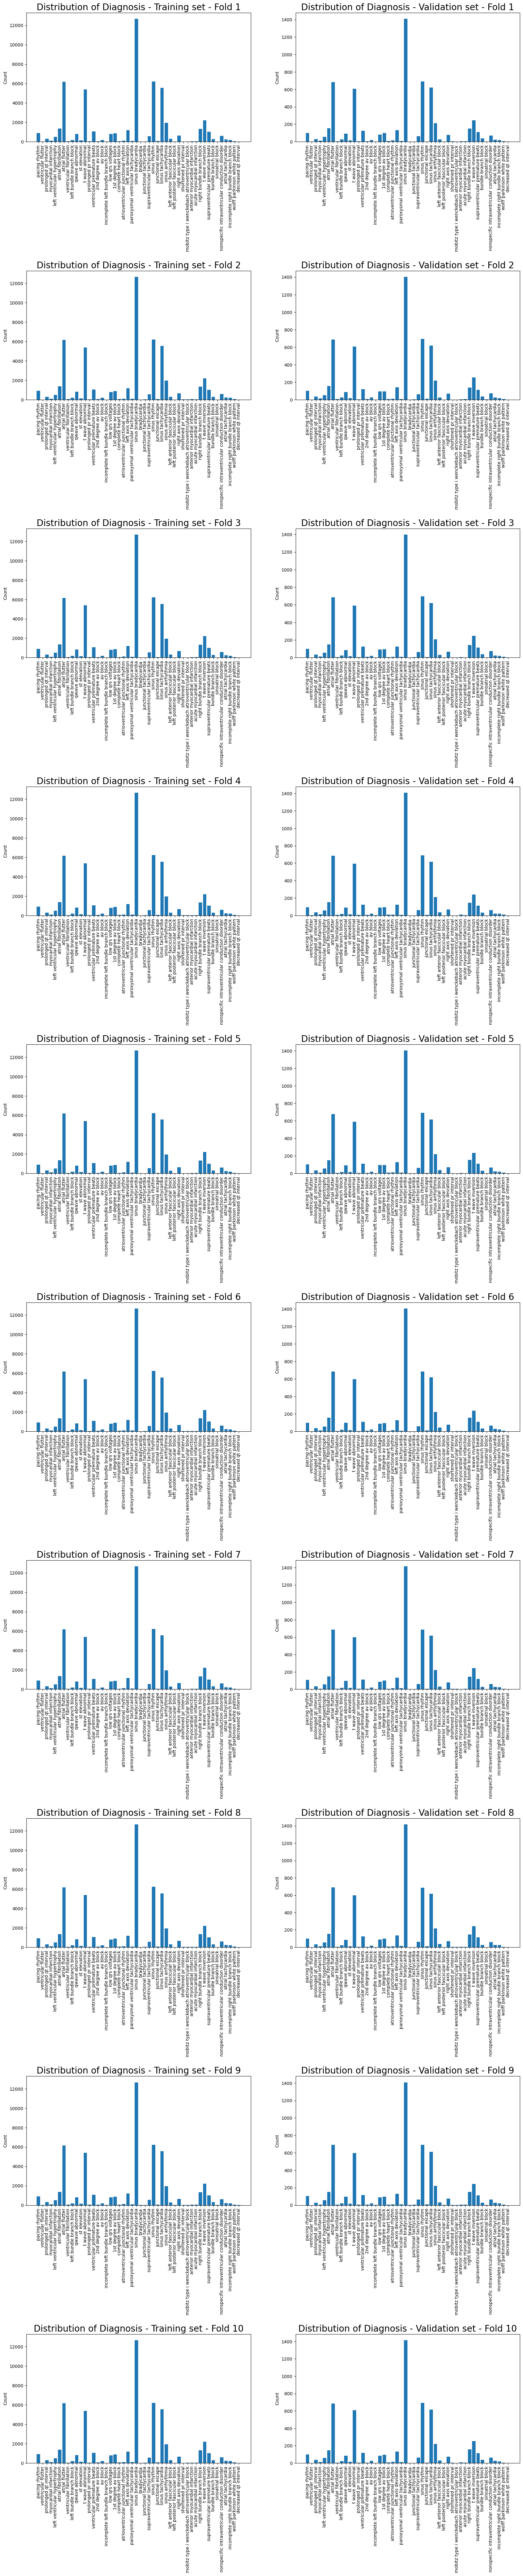

In [ ]:
hf.plot_all_folds(folds_train, y[train_index] ,snomed_classes)

Batch generator, because dataset is to large for RAM capacity:

In [ ]:
order_array = folds_train[0][0]

def shuffle_batch_generator(batch_size, gen_x, gen_y):
    np.random.shuffle(order_array)
    batch_data = np.zeros((batch_size, 5000, 12))                   # (batch_size,samp_freq*time, num_leads)
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0]))   #drop undef class

    while True:
        for i in range(batch_size):

            batch_data[i] = next(gen_x)
            batch_labels[i] = next(gen_y)

        yield batch_data, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = hf.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new


# Imbalanced data - Class weights
Each label can be given a weight which decides how much the ResNet will learn from the different labels. This could be prefered above resampling to standardized amounts of samples as with the resample technique a lot of samples, and therefore data to train the network on, are lost.
As it's mainly important that the model is able to correctly identify the minority classes, so the arrhytmia's, dealing with the data imbalance is important.

In [ ]:
new_weights= hf.calculating_class_weights(y_train)

In [ ]:
keys = np.arange(0,len(new_weights),1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary


{0: 19.11304780876494,
 1: 3198.25,
 2: 57.28208955223881,
 3: 182.75714285714287,
 4: 34.89,
 5: 12.683079973562458,
 6: 2.8009779594219824,
 7: 383.79,
 8: 94.06617647058823,
 9: 21.227323008849556,
 10: 127.93,
 11: 3.205194588274595,
 12: 436.125,
 13: 16.30373831775701,
 14: 342.66964285714283,
 15: 92.70289855072464,
 16: 3837.9,
 17: 21.634160090191656,
 18: 19.80340557275542,
 19: 295.2230769230769,
 20: 162.6228813559322,
 21: 14.615003808073116,
 22: 206.33870967741936,
 23: 1.3633747779751333,
 24: 3198.25,
 25: 959.475,
 26: 31.202439024390245,
 27: 2.7786707211120762,
 28: 299.8359375,
 29: 3.112147259163153,
 30: 8.855329949238579,
 31: 59.410216718266255,
 32: 4797.375,
 33: 26.468275862068964,
 34: 959.475,
 35: 738.0576923076923,
 36: 399.78125,
 37: 456.89285714285717,
 38: 12.939649359406609,
 39: 7.848466257668711,
 40: 17.087711487088157,
 41: 58.68348623853211,
 42: 4797.375,
 43: 29.296946564885495,
 44: 76.14880952380952,
 45: 91.8157894736842,
 46: 314.58196721

# Fitting the model

## Defining eval metrics and callbacks

In [ ]:
eval_metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy', dtype=None, threshold=0.5),
                tf.keras.metrics.Recall(name='Recall'),
                tf.keras.metrics.Precision(name='Precision'),
                tf.keras.metrics.AUC(num_thresholds=200,
                                      curve="ROC",
                                      summation_method="interpolation",
                                      name="AUC",
                                      dtype=None,
                                      thresholds=None,
                                      multi_label=True,
                                      label_weights=None,
    )]

lr=0.001
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,          # 2 epochs of patience with no improvement after which lr is decreased by factor
    min_lr=lr / 100
    )
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=5,          # Patience should be larger than the one in ReduceLROnPlateau
    restore_best_weights=True
    )

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Python_Syncope/baselineRNN_model.h5', save_best_only=True)

callback = [reduce_lr, early_stopping, checkpoint]
#callback = [reduce_lr, early_stopping]

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import model as RNN

with tf.device(device_name):
  RNNmodel = RNN.model(n_classes=snomed_classes.shape[0],
                     kernel_size=16, dropout_keep_prob=0.8, learning_rate=0.001,
                     kernel_initializer='he_normal', activation_function='relu', last_layer='sigmoid',
                     loss_function='binary_crossentropy', metrics=eval_metrics)

In [ ]:
RNNmodel.summary()
#plot_model(RNNmodel)

Model: "ResNet_Ribeiro"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal (InputLayer)         [(None, 5000, 12)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 5000, 64)             12288     ['signal[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 5000, 64)             256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 5000, 64)             0         ['batch_normaliza

In [ ]:
batchsize = 64
#history = RNNmodel.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames[train_index]), gen_y=generate_y_shuffle(y[train_index])),
#    epochs=50, steps_per_epoch=(len(order_array)/(batchsize)),
#    class_weight=weight_dictionary,
#    callbacks=callback,
#    validation_data=hf.generate_validation_data(ecg_filenames[train_index],y[train_index],folds_train[0][1]), validation_freq=1
#    )

# Save final result
#RNNmodel.save("/content/drive/MyDrive/Python_Syncope/baselineRNNmodel.hdf5")


# Load pre-trained model
RNNmodel = load_model('/content/drive/MyDrive/Python_Syncope/baselineRNNmodel.hdf5')
#RNNmodel.load_weights("/content/drive/MyDrive/Python_Syncope/baselineRNNmodel.h5")


Epoch 1/50
539/539 [==============================] - 36s 54ms/step - loss: 1.8743 - accuracy: 0.9687 - Recall: 0.2349 - Precision: 0.5521 - AUC: 0.6459 - val_loss: 0.3653 - val_accuracy: 0.9515 - val_Recall: 0.0220 - val_Precision: 0.0423 - val_AUC: 0.4505 - lr: 0.0010
Epoch 2/50
539/539 [==============================] - 28s 52ms/step - loss: 1.4822 - accuracy: 0.9717 - Recall: 0.3196 - Precision: 0.6344 - AUC: 0.7230 - val_loss: 0.1095 - val_accuracy: 0.9682 - val_Recall: 0.4060 - val_Precision: 0.5201 - val_AUC: 0.6734 - lr: 0.0010
Epoch 3/50
539/539 [==============================] - 28s 52ms/step - loss: 1.2135 - accuracy: 0.9731 - Recall: 0.3760 - Precision: 0.6552 - AUC: 0.7626 - val_loss: 0.0944 - val_accuracy: 0.9739 - val_Recall: 0.3558 - val_Precision: 0.7034 - val_AUC: 0.6803 - lr: 0.0010
Epoch 4/50
539/539 [==============================] - 28s 51ms/step - loss: 1.0973 - accuracy: 0.9742 - Recall: 0.4311 - Precision: 0.6626 - AUC: 0.7936 - val_loss: 0.0747 - val_accuracy:

### Generate plots to visualize performance model

Text(0, 0.5, 'Accuracy/AUC')

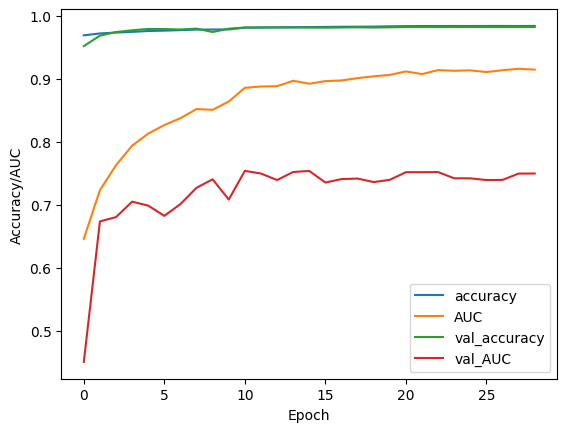

In [ ]:
plt.plot(RNNmodel.history.history['accuracy'])
plt.plot(RNNmodel.history.history['AUC'])
plt.plot(RNNmodel.history.history['val_accuracy'])
plt.plot(RNNmodel.history.history['val_AUC'])
plt.legend(("accuracy","AUC","val_accuracy","val_AUC"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy/AUC')

Text(0, 0.5, 'Loss')

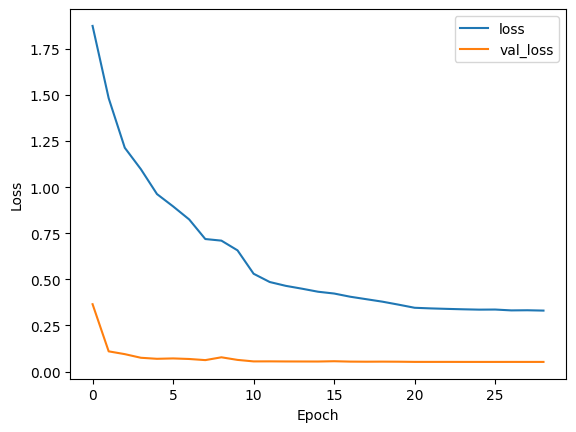

In [ ]:
plt.plot(RNNmodel.history.history['loss'])
plt.plot(RNNmodel.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

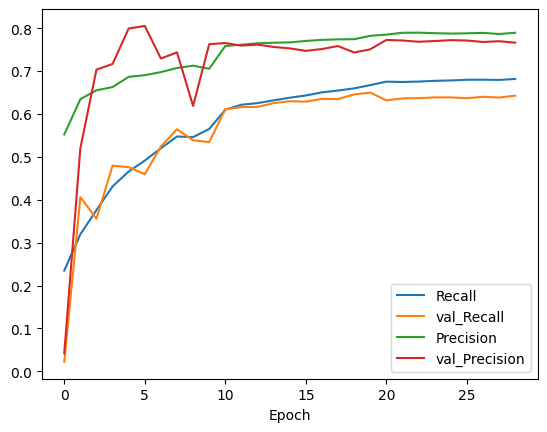

In [ ]:
plt.plot(RNNmodel.history.history['Recall'])
plt.plot(RNNmodel.history.history['val_Recall'])
plt.plot(RNNmodel.history.history['Precision'])
plt.plot(RNNmodel.history.history['val_Precision'])
plt.legend(("Recall","val_Recall","Precision", "val_Precision"))
plt.xlabel('Epoch')

### Test scores

In [ ]:
x_test, y_test = hf.generate_validation_data(ecg_filenames, y, test_index)
y_pred = RNNmodel.predict(x=x_test)
threshold = 0.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

212/212 [==============================] - 2s 7ms/step


In [ ]:
model_report = classification_report(y_test, y_pred_binary)
print(model_report)

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       177
           1       0.00      0.00      0.00         1
           2       0.10      0.12      0.11        59
           3       0.19      0.22      0.21        18
           4       0.44      0.62      0.52        97
           5       0.25      0.37      0.30       267
           6       0.77      0.49      0.60      1209
           7       0.67      0.89      0.76         9
           8       0.39      0.31      0.34        36
           9       0.33      0.21      0.25       159
          10       0.07      0.12      0.09        26
          11       0.63      0.47      0.54      1056
          12       0.00      0.00      0.00         8
          13       0.82      0.68      0.74       208
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        37
          16       0.00      0.00      0.00         1
          17       0.38    

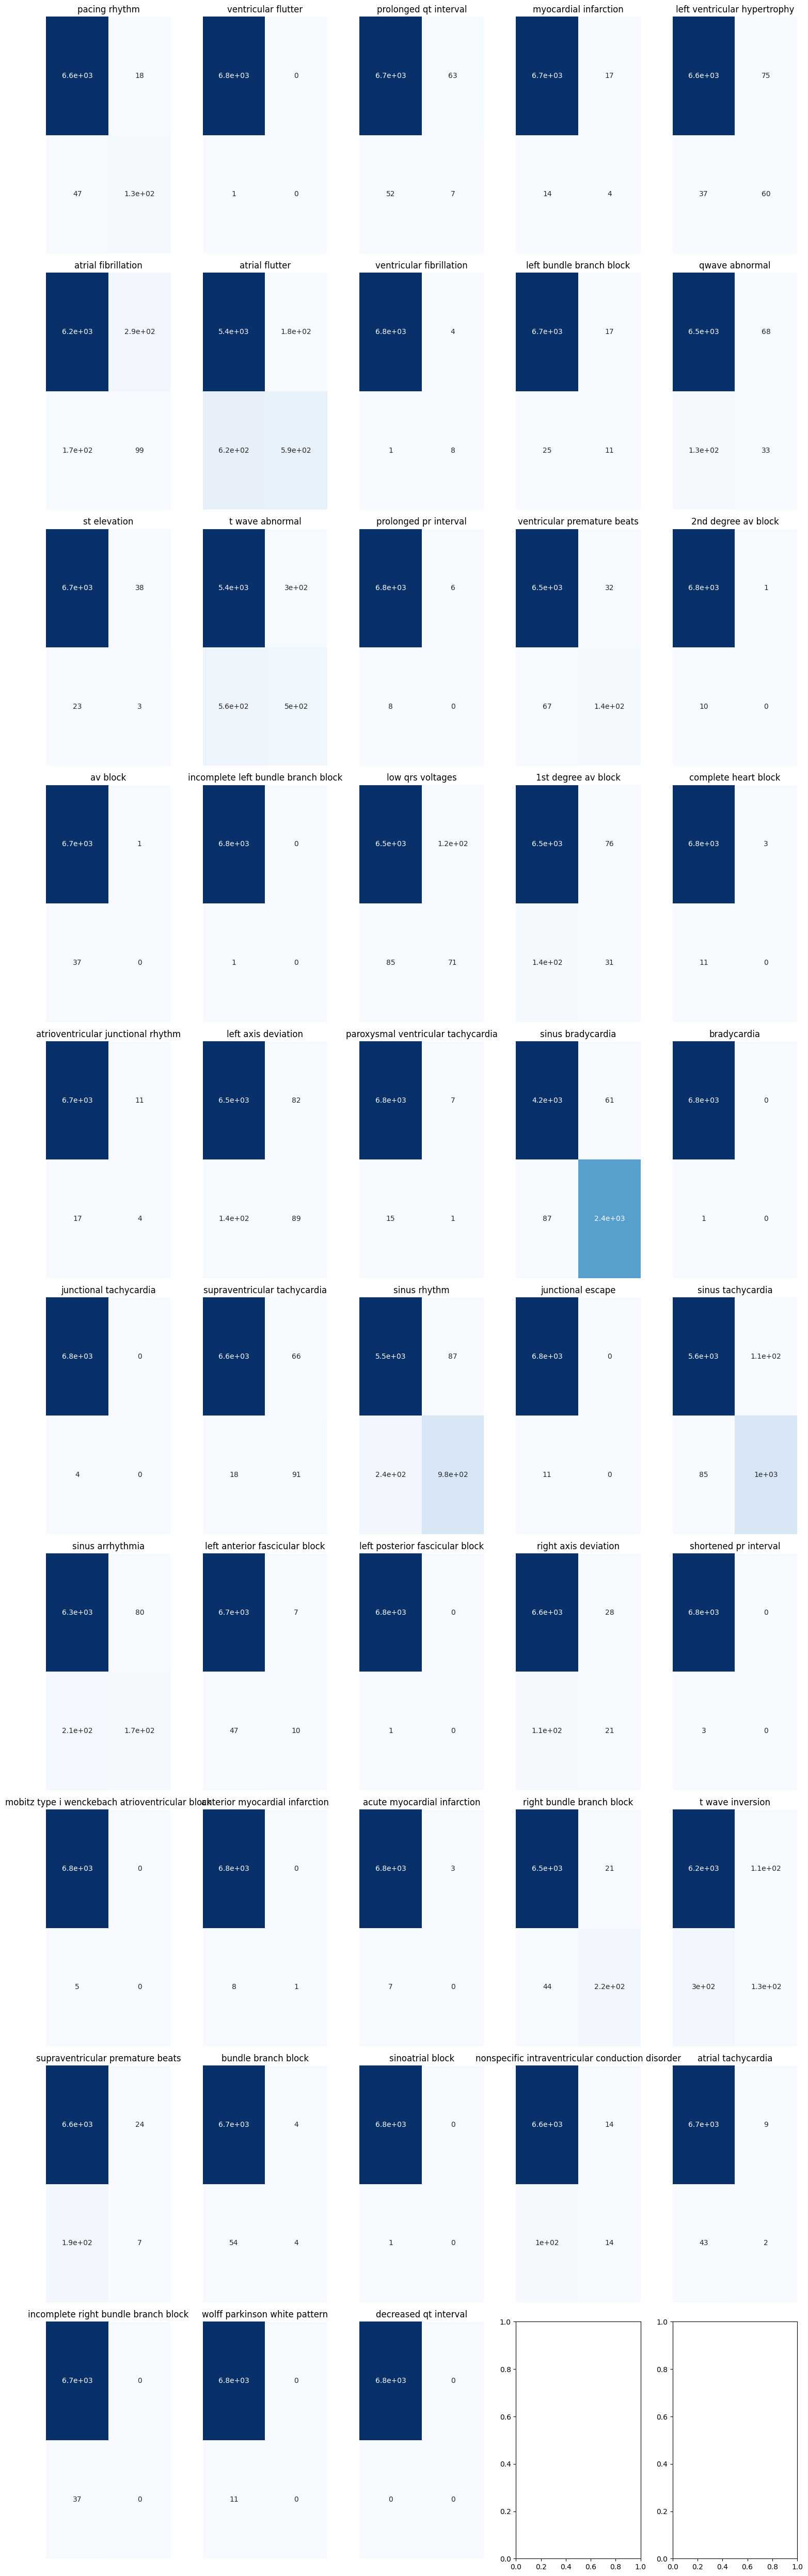

In [ ]:
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=len(snomed_classes))
metric.update_state(y_test, y_pred_binary)
cm = metric.result()
cm.numpy()

fig, axes = plt.subplots(round(len(snomed_classes)/5), 5, figsize=(15, (5*round(len(snomed_classes)/5))))

for i, label in enumerate(snomed_classes):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    # confusion matrix
    sns.heatmap(cm[i], annot=True, cmap='Blues', cbar=False, ax=ax)

    ax.set_title(label)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

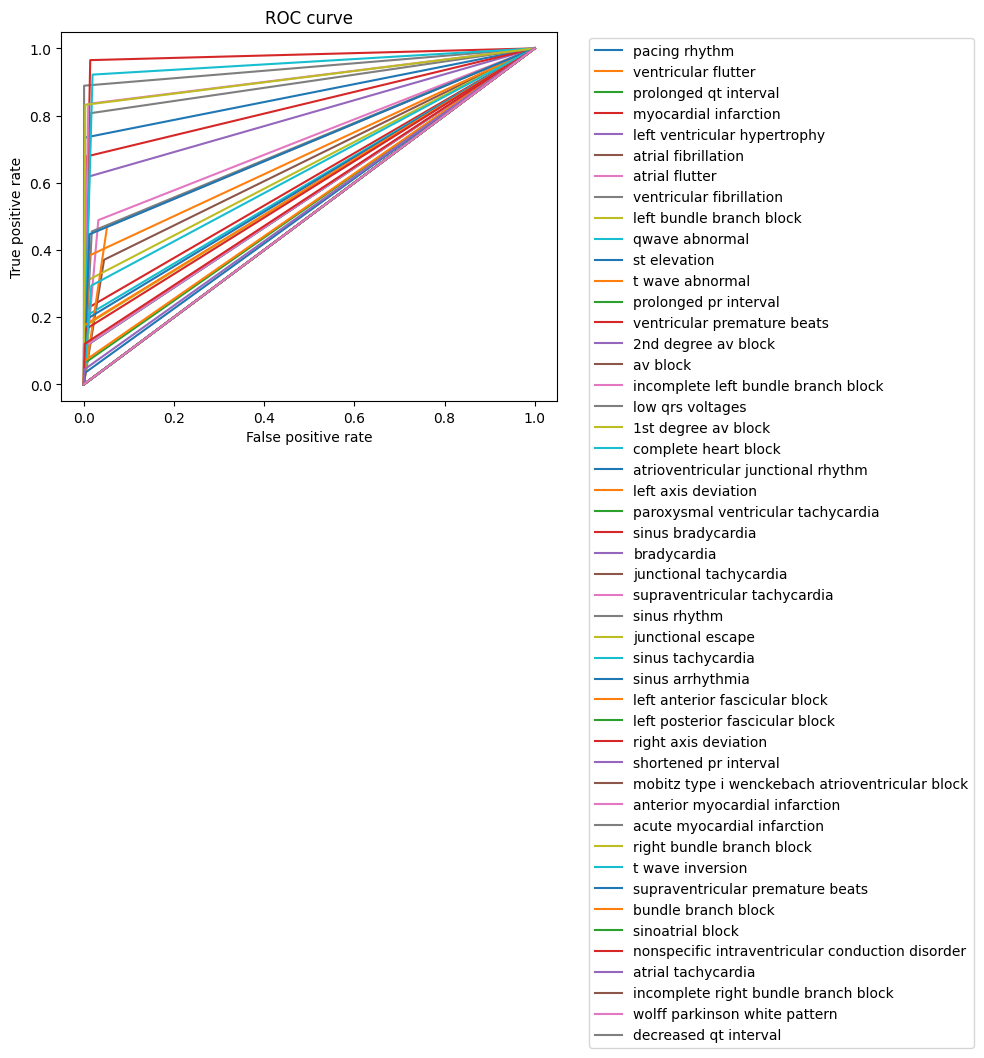

In [ ]:
num_classes = len(snomed_classes)
fpr = [0] * num_classes
tpr = [0] * num_classes
roc_aucTest = [0] * num_classes
label_to_index = {label: index for index, label in enumerate(snomed_classes)}
for label in snomed_classes:
    i = label_to_index[label]
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_aucTest[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for label in snomed_classes:
  i = label_to_index[label]
  plt.plot(fpr[i], tpr[i], label=label)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Hyperparameter tuning of original model

In [ ]:
hp = HyperParameters()

class defining_hypermodel(kt.HyperModel):
        def build(self, hp):
                hypermodel = RNN.model(
                        n_classes=snomed_classes.shape[0],
                        kernel_size= hp.Choice(name='kernel_size', values=[8, 16, 24, 32]),
                        dropout_keep_prob= hp.Choice(name="dropout", values=[0.5, 0.6, 0.7, 0.7, 0.8, 0.9]),
                        learning_rate= hp.Choice(name='learning_rate', values=[0.05, 0.01, 0.005, 0.001]),
                        kernel_initializer= hp.Choice(name='Initializer', values=['he_normal', 'truncated_normal', 'orthogonal']),
                        activation_function=hp.Choice(name='Activation', values=['Relu','Sigmoid', 'Tanh']),
                        last_layer='sigmoid',
                        loss_function='binary_crossentropy',
                        metrics=eval_metrics
                        )
                return hypermodel

        def fit(self, hp, hypermodel, *args, **kwargs):
                return hypermodel.fit(
                        batch_size = hp.Choice(name='batch_size', values=[16, 32, 64, 128]),
                        *args,
                        **kwargs,
                )

In [ ]:
with tf.device(device_name):
  tuner = kt.BayesianOptimization(
                  defining_hypermodel(),
                  objective = 'val_loss', # kt.Objective("val_Recall", direction='max'), #optimize val lrecall (minimize false negatives and while maximizing true positives)
                  overwrite=True,  #overwrite previous results
                  max_trials = 20,
                  seed = 33,
                  directory='/content/drive/MyDrive/Python_Syncope', #Saving dir
                  project_name='Hyperparameter_tuning_OriginalModel'
                  )

# hypertuning settings
tuner.search_space_summary()

# callbacks hypeprmodel
checkpoints = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Python_Syncope/RNN_hypermodel.h5', save_freq='epoch', save_best_only=True)

callback = [reduce_lr, early_stopping, checkpoints]

Search space summary
Default search space size: 5
kernel_size (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 24, 32], 'ordered': True}
dropout (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 0.6, 0.7, 0.7, 0.8, 0.9], 'ordered': True}
learning_rate (Choice)
{'default': 0.05, 'conditions': [], 'values': [0.05, 0.01, 0.005, 0.001], 'ordered': True}
Initializer (Choice)
{'default': 'he_normal', 'conditions': [], 'values': ['he_normal', 'truncated_normal', 'orthogonal'], 'ordered': False}
Activation (Choice)
{'default': 'Relu', 'conditions': [], 'values': ['Relu', 'Sigmoid', 'Tanh'], 'ordered': False}


In [ ]:
# Perform hypertuning
#tuner.search(
#        x=shuffle_batch_generator(batch_size=hp.Choice(name='batch_size', values=[16, 32, 64, 128]),
#                                       gen_x=generate_X_shuffle(ecg_filenames[train_index]), gen_y=generate_y_shuffle(y[train_index])),
#        epochs=25, steps_per_epoch=(len(order_array)/(batchsize)),
#        class_weight=weight_dictionary,
#        callbacks=callback,
#        validation_data=hf.generate_validation_data(ecg_filenames[train_index],y[train_index],folds_train[0][1]), validation_freq=1)

best_hp=tuner.get_best_hyperparameters()[0]

Trial 20 Complete [00h 05m 18s]
val_loss: 0.0848415419459343

Best val_loss So Far: 0.07933712005615234
Total elapsed time: 01h 10m 41s


In [ ]:
# Build the model with the optimal hyperparameters
Best_model = tuner.hypermodel.build(best_hp)
Best_model.summary()

# print best hyperparameters:
print('Best kernel size:', best_hp.get('kernel_size'))
print('Best dropout keep prob:', best_hp.get('dropout'))
print('Best learning rate:', best_hp.get('learning_rate'))
print('Best Initializer:', best_hp.get('Initializer'))
print('Best activation function:', best_hp.get('Activation'))
print('Best batch size:', best_hp.get('batch_size'))

Model: "ResNet_Ribeiro"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal (InputLayer)         [(None, 5000, 12)]           0         []                            
                                                                                                  
 conv1d_13 (Conv1D)          (None, 5000, 64)             18432     ['signal[0][0]']              
                                                                                                  
 batch_normalization_9 (Bat  (None, 5000, 64)             256       ['conv1d_13[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_9 (Activation)   (None, 5000, 64)             0         ['batch_normaliza

In [ ]:
# Build the model with the optimal hyperparameters
#Best_model = tuner.hypermodel.build(best_hp)
#Best_model.summary()

#batch_size = best_hp.get('batch_size')

#history = Best_model.fit(
#    x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames[train_index]), gen_y=generate_y_shuffle(y[train_index])),
#    epochs=50, steps_per_epoch=(len(order_array)/(batchsize)),
#    class_weight=weight_dictionary,
#    callbacks=[reduce_lr,early_stopping],
#    validation_data=hf.generate_validation_data(ecg_filenames[train_index],y[train_index],folds_train[0][1]), validation_freq=1
#    )

# Save final result
#Best_model.save("/content/drive/MyDrive/Python_Syncope/hyperparameter_RNNmodel.hdf5")

Best_model = load_model('/content/drive/MyDrive/Python_Syncope/hyperparameter_RNNmodel.hdf5')

### Generate plots to visualize performance model

In [ ]:
plt.plot(Best_model.history.history['accuracy'])
plt.plot(Best_model.history.history['AUC'])
plt.plot(Best_model.history.history['val_accuracy'])
plt.plot(Best_model.history.history['val_AUC'])
plt.legend(("accuracy","AUC","val_accuracy","val_AUC"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy/AUC')

KeyError: 'accuracy'

In [ ]:
plt.plot(Best_model.history.history['loss'])
plt.plot(Best_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

KeyError: 'loss'

Text(0.5, 0, 'Epoch')

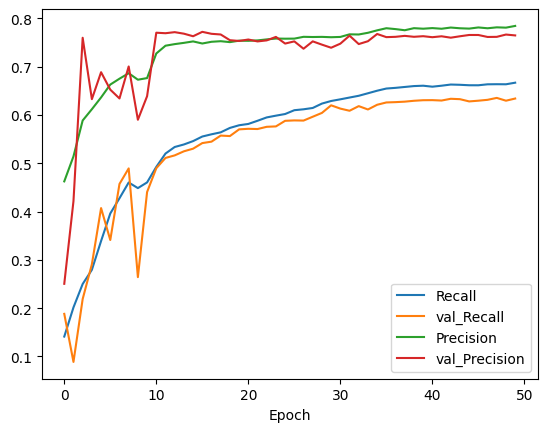

In [ ]:
plt.plot(Best_model.history.history['Recall'])
plt.plot(Best_model.history.history['val_Recall'])
plt.plot(Best_model.history.history['Precision'])
plt.plot(Best_model.history.history['val_Precision'])
plt.legend(("Recall","val_Recall","Precision", "val_Precision"))
plt.xlabel('Epoch')

## Test scores

In [ ]:
x_test, y_test = hf.generate_validation_data(ecg_filenames, y, test_index)
y_pred = Best_model.predict(x=x_test)
threshold = 0.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

212/212 [==============================] - 211s 991ms/step


In [ ]:
model_report = classification_report(y_test, y_pred_binary, target_names=snomed_classes)
print(model_report)

                                                  precision    recall  f1-score   support

                                   pacing rhythm       0.91      0.82      0.86       177
                             ventricular flutter       1.00      1.00      1.00         1
                           prolonged qt interval       0.33      0.39      0.36        59
                           myocardial infarction       0.68      0.72      0.70        18
                    left ventricular hypertrophy       0.48      0.75      0.59        97
                             atrial fibrillation       0.27      0.42      0.33       267
                                  atrial flutter       0.79      0.48      0.59      1209
                        ventricular fibrillation       1.00      1.00      1.00         9
                        left bundle branch block       0.53      0.44      0.48        36
                                  qwave abnormal       0.45      0.19      0.27       159
         

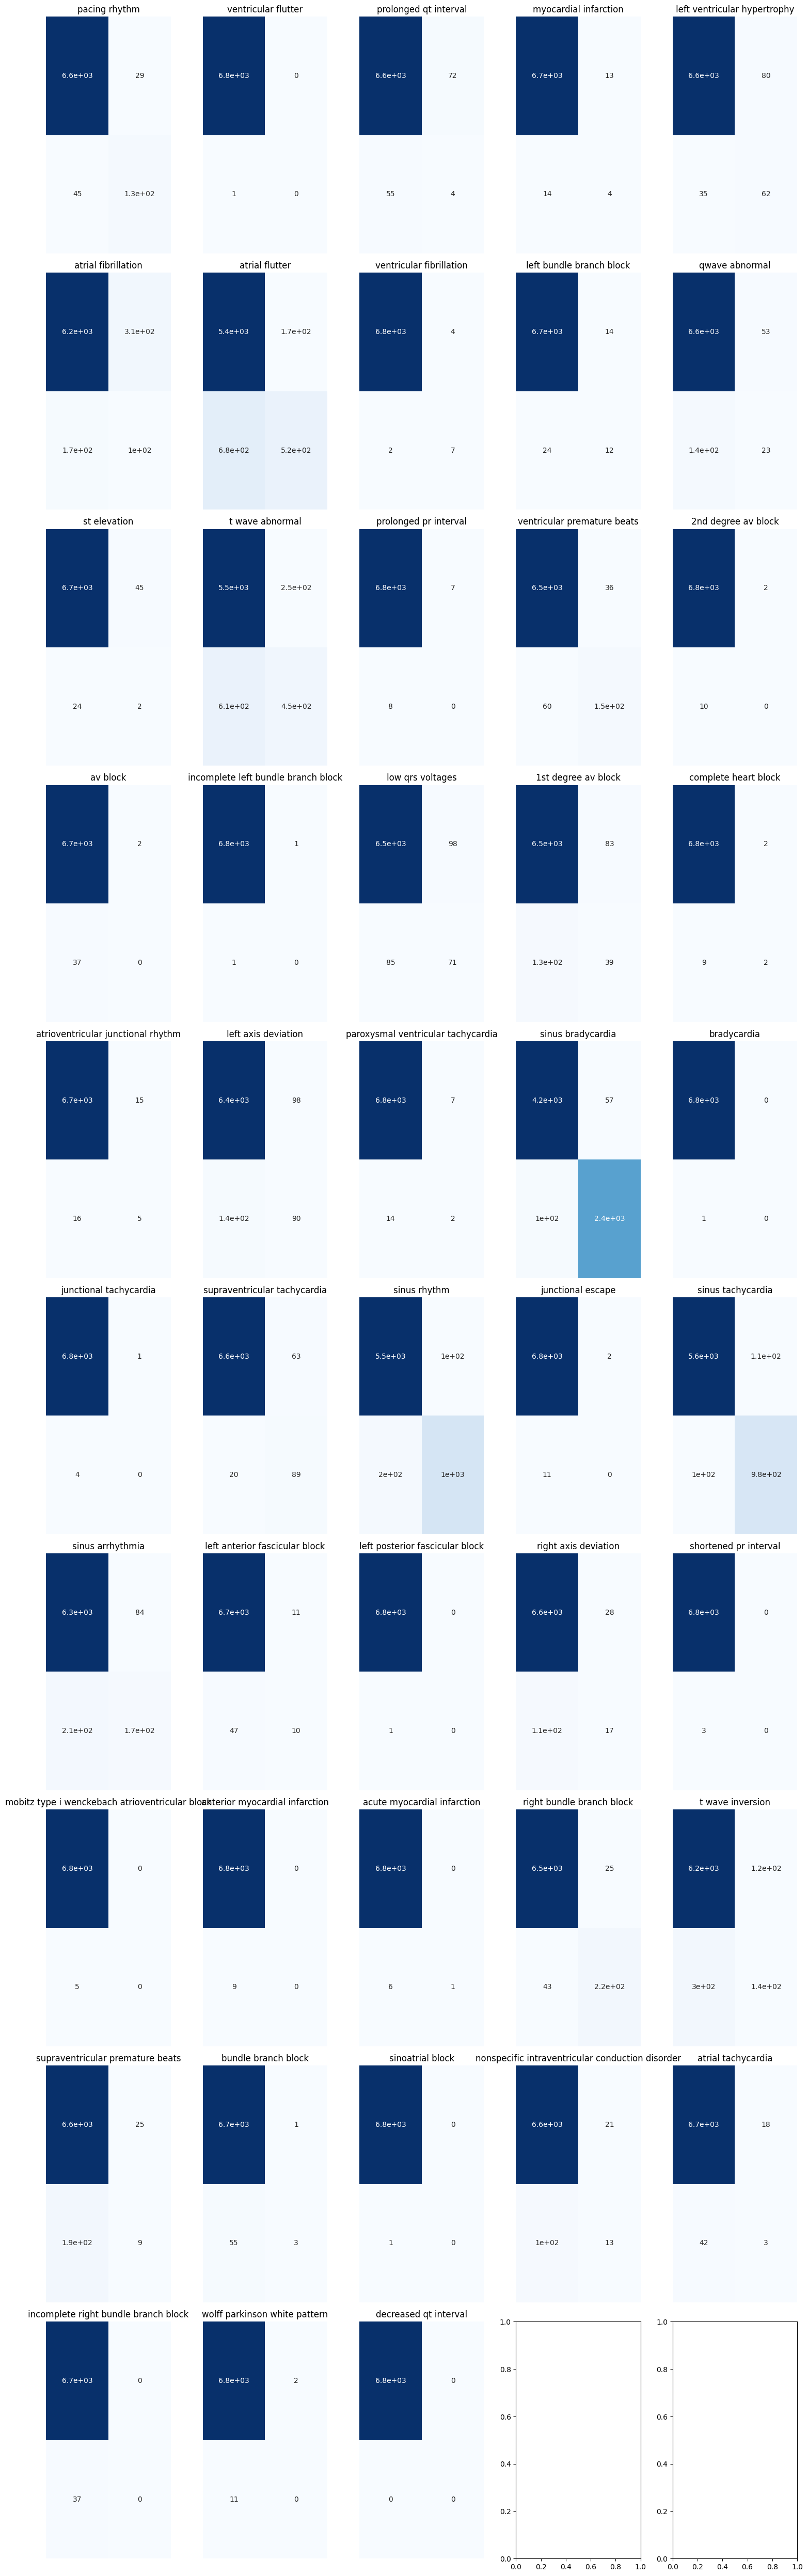

In [ ]:
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=len(snomed_classes))
metric.update_state(y_test, y_pred_binary)
cm = metric.result()
cm.numpy()

fig, axes = plt.subplots(round(len(snomed_classes)/5), 5, figsize=(15, (5*round(len(snomed_classes)/5))))

for i, label in enumerate(snomed_classes):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    # confusion matrix
    sns.heatmap(cm[i], annot=True, cmap='Blues', cbar=False, ax=ax)

    ax.set_title(label)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

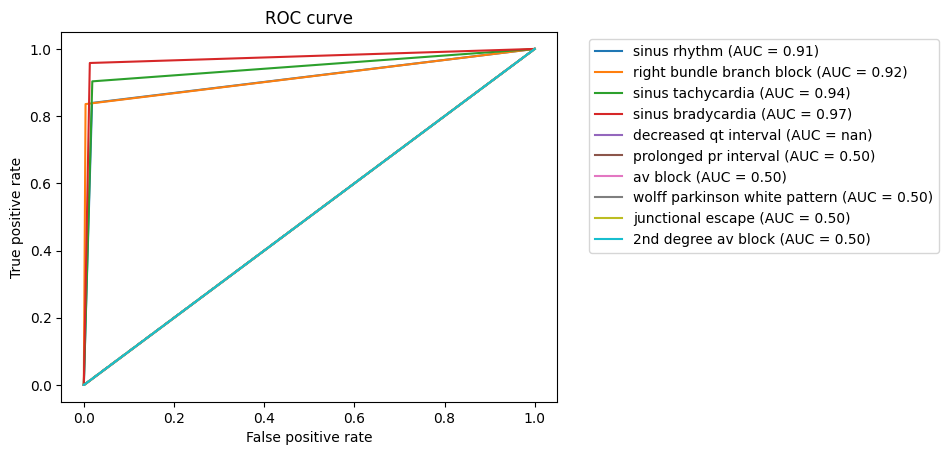

In [ ]:
# Sort AUC values and get indices of top 5 and bottom 5
top_indices = np.argsort(roc_aucTest)[-5:]
bottom_indices = np.argsort(roc_aucTest)[:5]

# Plot the ROC curves for the top 5 and bottom 5 AUC
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line

# Plot top 5 AUC curves
for i in top_indices:
    plt.plot(fpr[i], tpr[i], label=f'{snomed_classes[i]} (AUC = {roc_aucTest[i]:.2f})')

# Plot bottom 5 AUC curves
for i in bottom_indices:
    plt.plot(fpr[i], tpr[i], label=f'{snomed_classes[i]} (AUC = {roc_aucTest[i]:.2f})')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

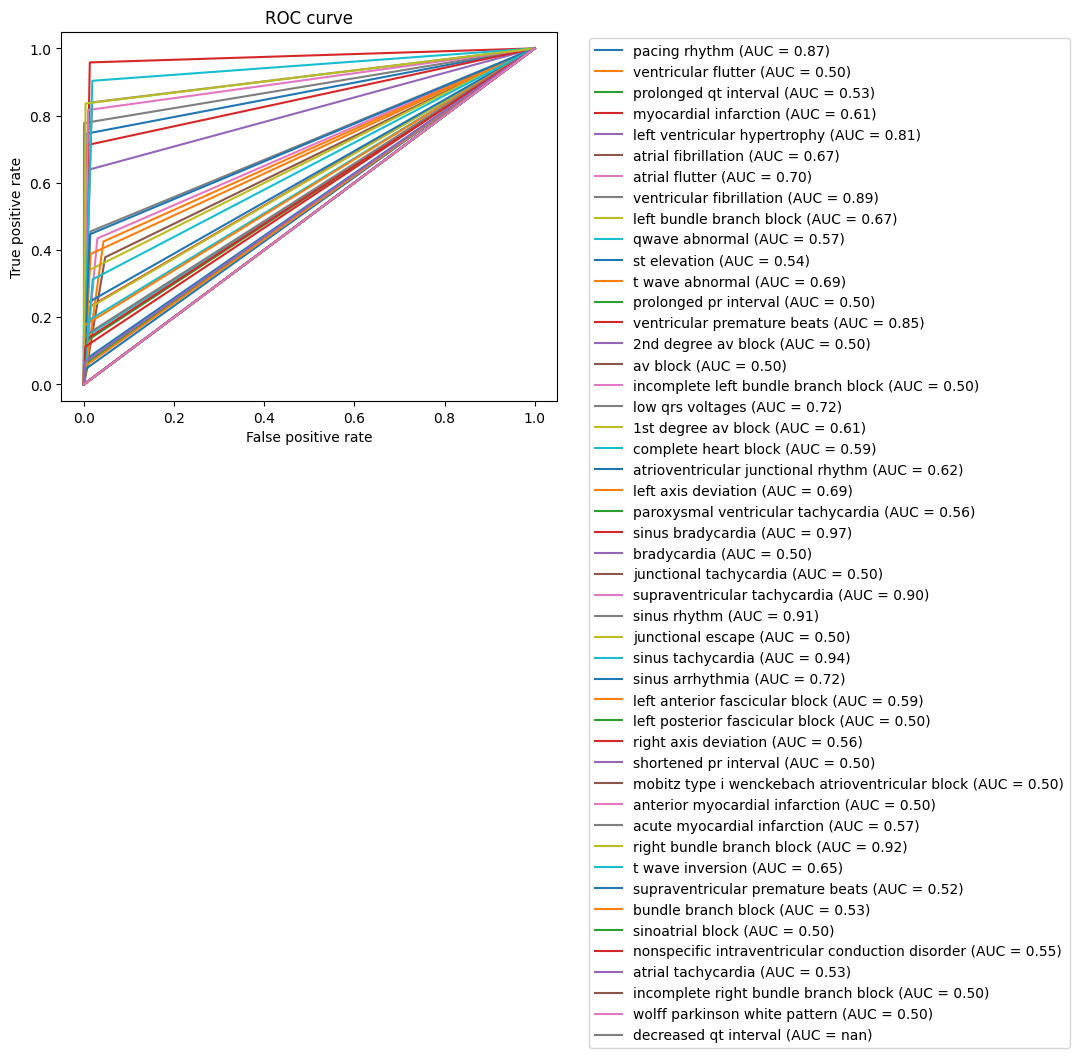

In [ ]:
num_classes = len(snomed_classes)
fpr = [0] * num_classes
tpr = [0] * num_classes
roc_aucTest = [0] * num_classes
label_to_index = {label: index for index, label in enumerate(snomed_classes)}
for label in snomed_classes:
    i = label_to_index[label]
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_aucTest[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for label in snomed_classes:
  i = label_to_index[label]
  plt.plot(fpr[i], tpr[i], label=f'{snomed_classes[i]} (AUC = {roc_aucTest[i]:.2f})')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Fitting RNN model with attention modules

## ECA attention model

In [ ]:
import ECA_RNNmodel as ECAttentionRNN

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Python_Syncope/ECA_RNN_model.h5', save_best_only=True)
callback = [reduce_lr, early_stopping, checkpoint] #, TensorBoard('/content/drive/Mydrive/Python_syncope/baseline_ECAttentionModel', update_freq='epoch')]

with tf.device(device_name):
  ECA_RNNmodel = ECAttentionRNN.model(n_classes=snomed_classes.shape[0],
                     kernel_size=16, dropout_keep_prob=0.8, learning_rate=0.001,
                     kernel_initializer='he_normal', activation_function='relu', last_layer='softmax',
                     loss_function='binary_crossentropy', metrics=eval_metrics
                       )

In [ ]:
ECA_RNNmodel.summary()
#plot_model(RNNmodel)

Model: "ResNet_Ribeiro"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal (InputLayer)         [(None, 5000, 12)]           0         []                            
                                                                                                  
 conv1d_65 (Conv1D)          (None, 5000, 64)             12288     ['signal[0][0]']              
                                                                                                  
 batch_normalization_45 (Ba  (None, 5000, 64)             256       ['conv1d_65[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_45 (Activation)  (None, 5000, 64)             0         ['batch_normaliza

In [ ]:
batchsize = 64

#history = ECA_RNNmodel.fit(
#    x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames[train_index]), gen_y=generate_y_shuffle(y[train_index])),
#    epochs=50, steps_per_epoch=(len(order_array)/(batchsize)),
#    class_weight=weight_dictionary,
#    callbacks=callback,
#    validation_data=hf.generate_validation_data(ecg_filenames[train_index],y[train_index],folds_train[0][1]), validation_freq=1
#    )

# Save final result
ECA_RNNmodel.save("/content/drive/MyDrive/Baseline_ECA_RNNmodel.hdf5")

ECA_RNNmodel = load_model("/content/drive/MyDrive/Baseline_ECA_RNNmodel.hdf5"

Epoch 1/50
539/539 [==============================] - 35s 52ms/step - loss: 1.5547 - accuracy: 0.9717 - Recall: 0.1733 - Precision: 0.8237 - AUC: 0.6695 - val_loss: 0.1120 - val_accuracy: 0.9714 - val_Recall: 0.2175 - val_Precision: 0.7102 - val_AUC: 0.5839 - lr: 0.0010
Epoch 2/50
539/539 [==============================] - 29s 53ms/step - loss: 1.3134 - accuracy: 0.9731 - Recall: 0.2052 - Precision: 0.8869 - AUC: 0.7095 - val_loss: 0.0903 - val_accuracy: 0.9743 - val_Recall: 0.2796 - val_Precision: 0.8170 - val_AUC: 0.6277 - lr: 0.0010
Epoch 3/50
539/539 [==============================] - 28s 52ms/step - loss: 1.1619 - accuracy: 0.9756 - Recall: 0.2961 - Precision: 0.8761 - AUC: 0.7511 - val_loss: 0.0888 - val_accuracy: 0.9756 - val_Recall: 0.3019 - val_Precision: 0.8717 - val_AUC: 0.6586 - lr: 0.0010
Epoch 4/50
539/539 [==============================] - 28s 52ms/step - loss: 1.0410 - accuracy: 0.9769 - Recall: 0.3418 - Precision: 0.8826 - AUC: 0.7655 - val_loss: 0.0775 - val_accuracy:

### Generate plots to visualize performance model

Text(0, 0.5, 'Accuracy/AUC')

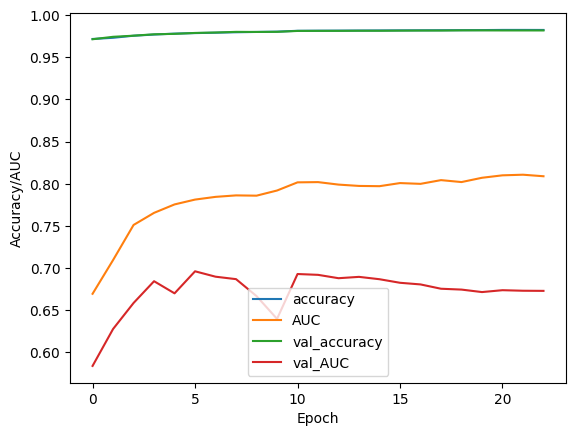

In [ ]:
plt.plot(ECA_RNNmodel.history.history['accuracy'])
plt.plot(ECA_RNNmodel.history.history['AUC'])
plt.plot(ECA_RNNmodel.history.history['val_accuracy'])
plt.plot(ECA_RNNmodel.history.history['val_AUC'])
plt.legend(("accuracy","AUC","val_accuracy","val_AUC"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy/AUC')

Text(0, 0.5, 'Loss')

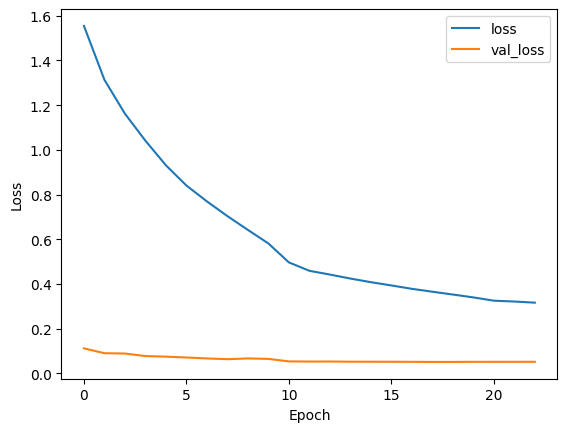

In [ ]:
plt.plot(ECA_RNNmodel.history.history['loss'])
plt.plot(ECA_RNNmodel.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

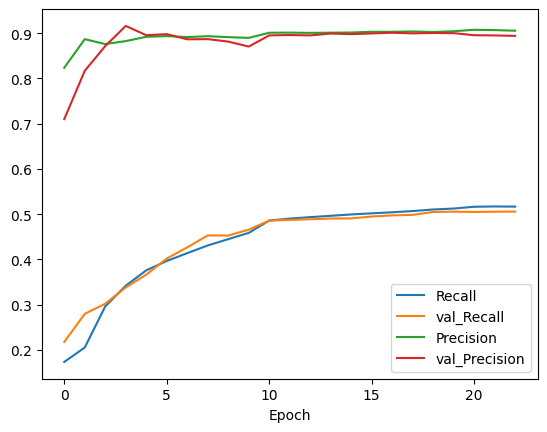

In [ ]:
plt.plot(ECA_RNNmodel.history.history['Recall'])
plt.plot(ECA_RNNmodel.history.history['val_Recall'])
plt.plot(ECA_RNNmodel.history.history['Precision'])
plt.plot(ECA_RNNmodel.history.history['val_Precision'])
plt.legend(("Recall","val_Recall","Precision", "val_Precision"))
plt.xlabel('Epoch')

### Test scores

In [ ]:
x_test, y_test = hf.generate_validation_data(ecg_filenames, y, test_index)
y_pred = ECA_RNNmodel.predict(x=x_test)
threshold = 0.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

212/212 [==============================] - 2s 6ms/step


In [ ]:
model_report = classification_report(y_test, y_pred_binary)
print(model_report)

              precision    recall  f1-score   support

           0       0.94      0.65      0.77       177
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        59
           3       0.67      0.11      0.19        18
           4       0.63      0.20      0.30        97
           5       0.18      0.07      0.11       267
           6       0.81      0.17      0.28      1209
           7       0.64      1.00      0.78         9
           8       0.60      0.08      0.15        36
           9       0.43      0.02      0.04       159
          10       0.00      0.00      0.00        26
          11       0.69      0.11      0.19      1056
          12       0.00      0.00      0.00         8
          13       0.87      0.54      0.67       208
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        37
          16       0.00      0.00      0.00         1
          17       0.65    

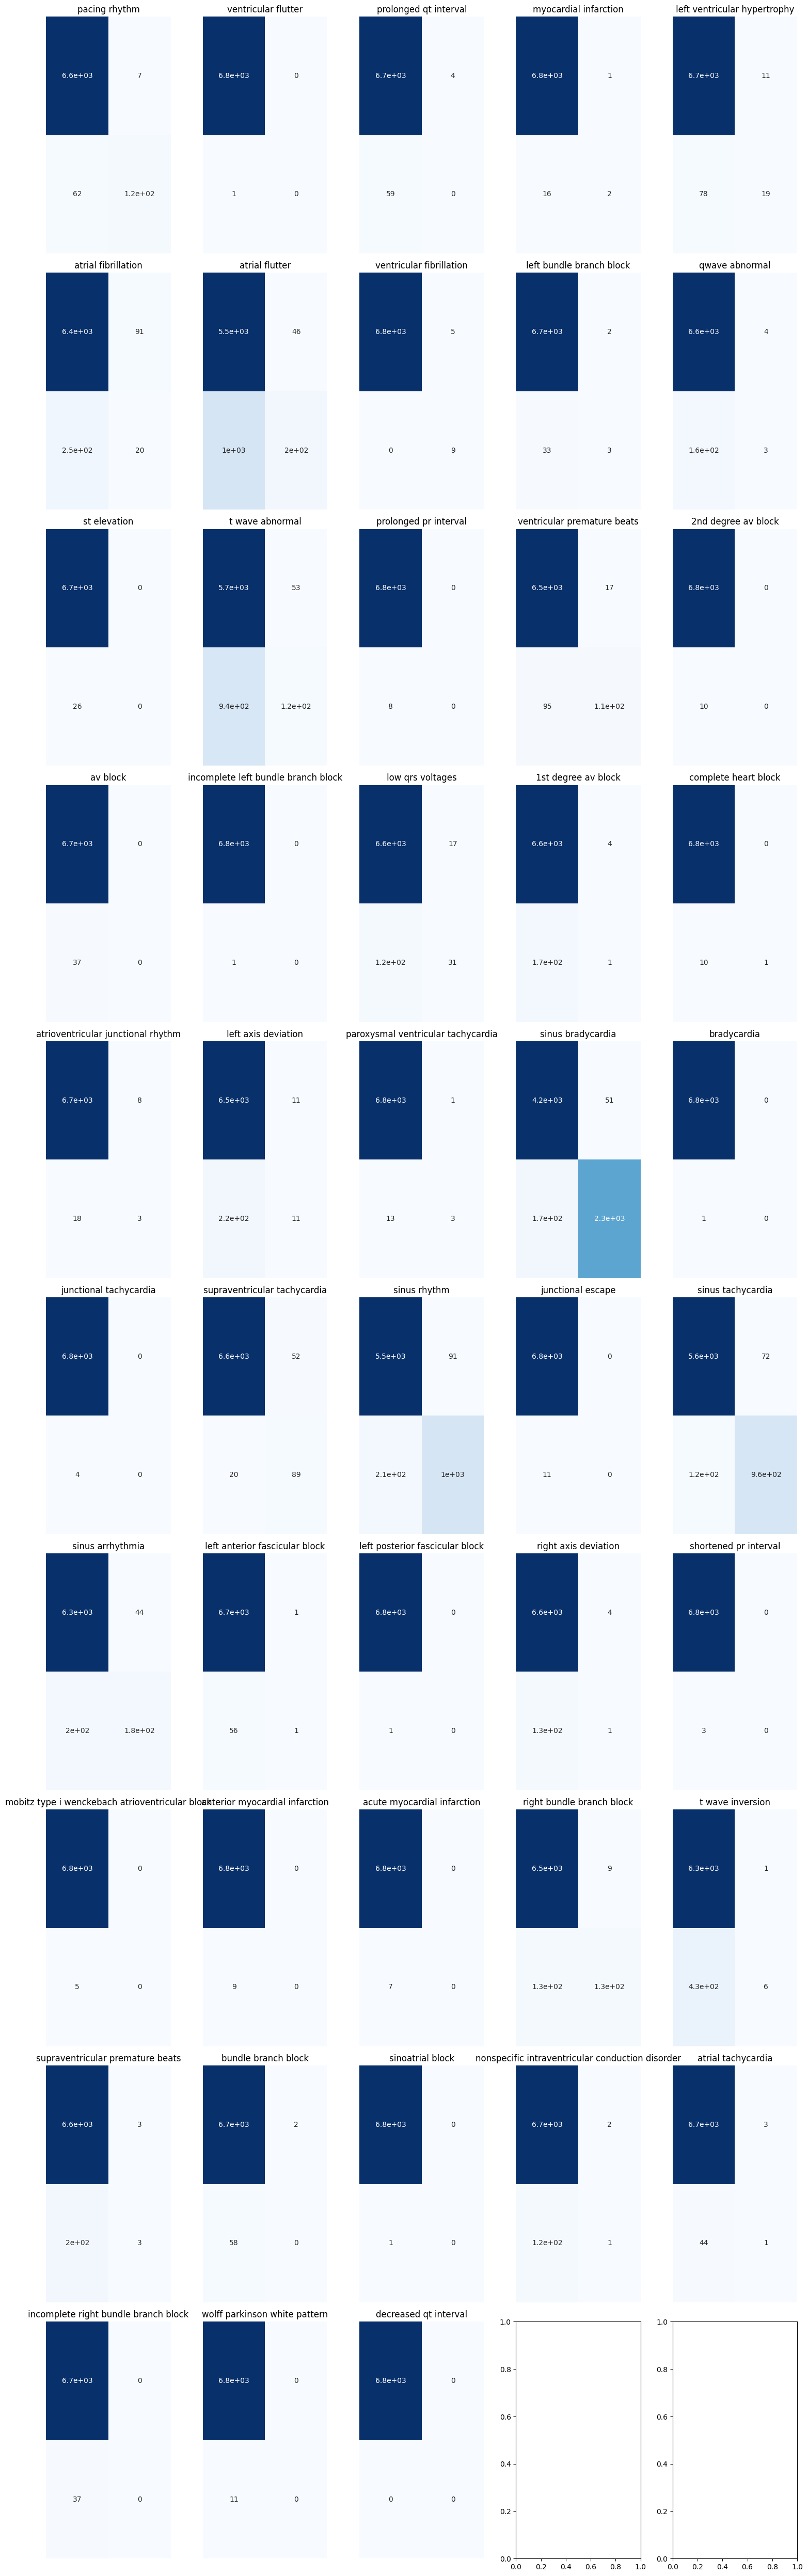

In [ ]:
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=len(snomed_classes))
metric.update_state(y_test, y_pred_binary)
cm = metric.result()
cm.numpy()

fig, axes = plt.subplots(round(len(snomed_classes)/5), 5, figsize=(15, (5*round(len(snomed_classes)/5))))

for i, label in enumerate(snomed_classes):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    # confusion matrix
    sns.heatmap(cm[i], annot=True, cmap='Blues', cbar=False, ax=ax)

    ax.set_title(label)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

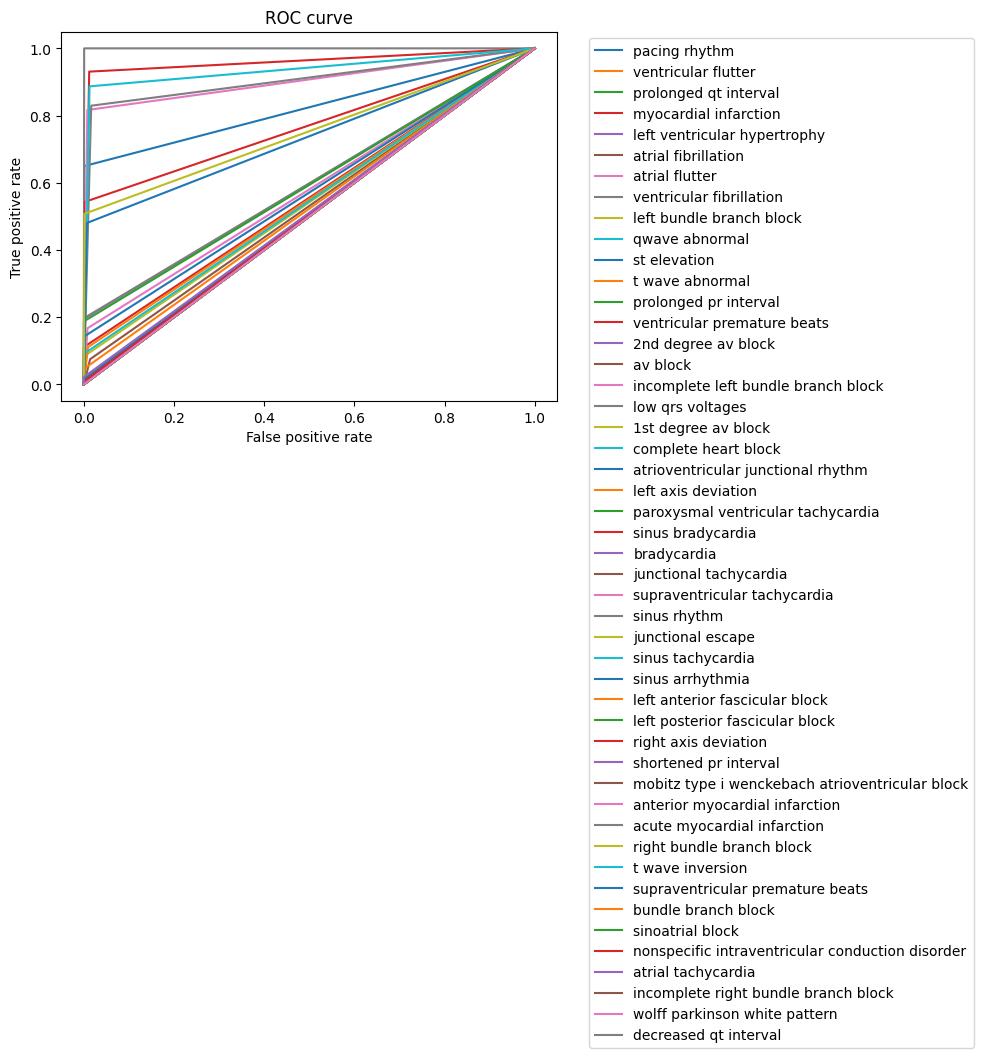

In [ ]:
num_classes = len(snomed_classes)
fpr = [0] * num_classes
tpr = [0] * num_classes
roc_aucTest = [0] * num_classes
label_to_index = {label: index for index, label in enumerate(snomed_classes)}
for label in snomed_classes:
    i = label_to_index[label]
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_aucTest[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for label in snomed_classes:
  i = label_to_index[label]
  plt.plot(fpr[i], tpr[i], label=label)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Hyperparameter tuning of best attention RNN model

In [ ]:
hp = HyperParameters()

class defining_hypermodel(kt.HyperModel):
        def build(self, hp):
                hypermodel = ECAttentionRNN.model(
                        n_classes=snomed_classes.shape[0],
                        kernel_size= hp.Choice(name='kernel_size', values=[8, 16, 24, 32]),
                        dropout_keep_prob= hp.Choice(name="dropout", values=[0.5, 0.6, 0.7, 0.7, 0.8, 0.9]),
                        learning_rate= hp.Choice(name='learning_rate', values=[0.05, 0.01, 0.005, 0.001]),
                        kernel_initializer= hp.Choice(name='Initializer', values=['he_normal', 'truncated_normal', 'orthogonal']),
                        activation_function=hp.Choice(name='Activation', values=['Relu','Sigmoid', 'Tanh']),
                        last_layer='sigmoid',
                        loss_function='binary_crossentropy',
                        metrics=eval_metrics
                        )
                return hypermodel

        def fit(self, hp, hypermodel, *args, **kwargs):
                return hypermodel.fit(
                        batch_size = hp.Choice(name='batch_size', values=[16, 32, 64, 128]),
                        *args,
                        **kwargs,
                )

In [ ]:
with tf.device(device_name):
  tuner = kt.BayesianOptimization(
                  defining_hypermodel(),
                  objective = 'val_loss', # kt.Objective("val_Recall", direction='max'), #optimize val lrecall (minimize false negatives and while maximizing true positives)
                  overwrite=True,  #overwrite previous results
                  max_trials = 20,
                  seed = 33,
                  directory='/content/drive/MyDrive/Python_Syncope', #Saving dir
                  project_name='Hyperparameter_tuning_ECAttentionRNNlModel'
                  )

# hypertuning settings
tuner.search_space_summary()

# callbacks hypeprmodel
# !tensorboard --logdir=path_to_your_logs
# http://localhost:6006/
checkpoints = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Python_Syncope/RNNattention_hypermodel.h5', save_freq='epoch', save_best_only=False)

callback = [reduce_lr, early_stopping, checkpoints, TensorBoard('content/drive/Mydrive/Python_syncope/Hyperparameter_tuning_attentionModel', update_freq='epoch', histogram_freq=1)]

Search space summary
Default search space size: 5
kernel_size (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 24, 32], 'ordered': True}
dropout (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 0.6, 0.7, 0.7, 0.8, 0.9], 'ordered': True}
learning_rate (Choice)
{'default': 0.05, 'conditions': [], 'values': [0.05, 0.01, 0.005, 0.001], 'ordered': True}
Initializer (Choice)
{'default': 'he_normal', 'conditions': [], 'values': ['he_normal', 'truncated_normal', 'orthogonal'], 'ordered': False}
Activation (Choice)
{'default': 'Relu', 'conditions': [], 'values': ['Relu', 'Sigmoid', 'Tanh'], 'ordered': False}


In [ ]:
# Perform hypertuning
#tuner.search(
#        x=shuffle_batch_generator(batch_size=hp.Choice(name='batch_size', values=[16, 32, 64, 128]),
#                                       gen_x=generate_X_shuffle(ecg_filenames[train_index]), gen_y=generate_y_shuffle(y[train_index])),
#        epochs=25, steps_per_epoch=(len(order_array)/(batchsize)),
#        class_weight=weight_dictionary,
#        callbacks=callback,
#        validation_data=hf.generate_validation_data(ecg_filenames[train_index],y[train_index],folds_train[0][1]), validation_freq=1)


Trial 20 Complete [00h 06m 37s]
val_loss: 0.08799435943365097

Best val_loss So Far: 0.08418252319097519
Total elapsed time: 01h 28m 39s


In [ ]:
# Build the model with the optimal hyperparameters
Best_model = tuner.hypermodel.build(best_hp)
Best_model.summary()

# print best hyperparameters:
print('Best kernel size:', best_hp.get('kernel_size'))
print('Best dropout keep prob:', best_hp.get('dropout'))
print('Best learning rate:', best_hp.get('learning_rate'))
print('Best Initializer:', best_hp.get('Initializer'))
print('Best activation function:', best_hp.get('Activation'))
print('Best batch size:', best_hp.get('batch_size'))

Model: "ResNet_Ribeiro"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal (InputLayer)         [(None, 5000, 12)]           0         []                            
                                                                                                  
 conv1d_13 (Conv1D)          (None, 5000, 64)             18432     ['signal[0][0]']              
                                                                                                  
 batch_normalization_9 (Bat  (None, 5000, 64)             256       ['conv1d_13[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_9 (Activation)   (None, 5000, 64)             0         ['batch_normaliza

In [ ]:
#batch_size = best_hp.get('batch_size')

#history = Best_model.fit(
#    x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames[train_index]), gen_y=generate_y_shuffle(y[train_index])),
#    epochs=75, steps_per_epoch=(len(order_array)/(batchsize)),
#    class_weight=weight_dictionary,
#    callbacks=[reduce_lr,early_stopping],
#    validation_data=hf.generate_validation_data(ecg_filenames[train_index],y[train_index],folds_train[0][1]), validation_freq=1
#    )

# Save final result
#Best_model.save("/content/drive/MyDrive/Python_Syncope/hyperparameter_attentionRNNmodel.hdf5")

Best_model = load_model("/content/drive/MyDrive/Python_Syncope/hyperparameter_attentionRNNmodel.hdf5")

### Generate plots to visualize performance model

Text(0, 0.5, 'Accuracy/AUC')

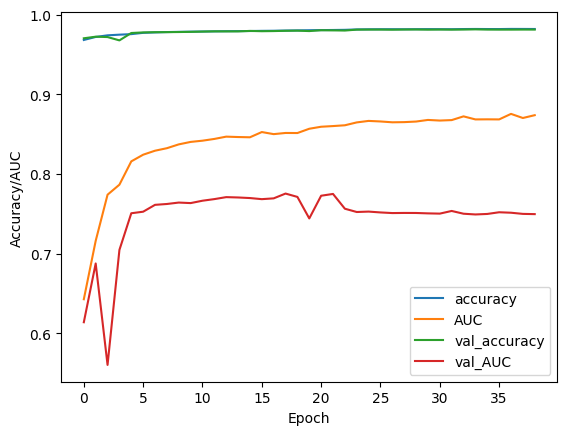

In [ ]:
plt.plot(Best_model.history.history['accuracy'])
plt.plot(Best_model.history.history['AUC'])
plt.plot(Best_model.history.history['val_accuracy'])
plt.plot(Best_model.history.history['val_AUC'])
plt.legend(("accuracy","AUC","val_accuracy","val_AUC"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy/AUC')

Text(0, 0.5, 'Loss')

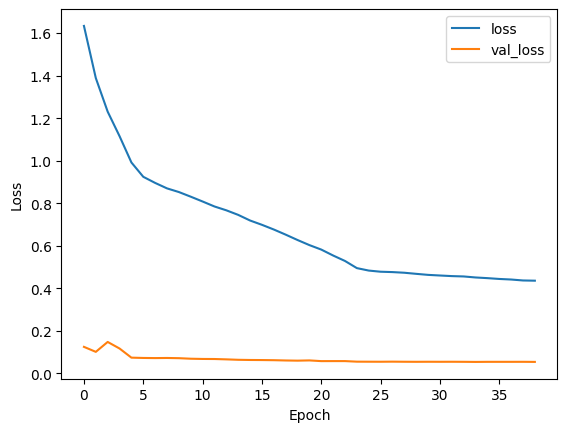

In [ ]:
plt.plot(Best_model.history.history['loss'])
plt.plot(Best_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

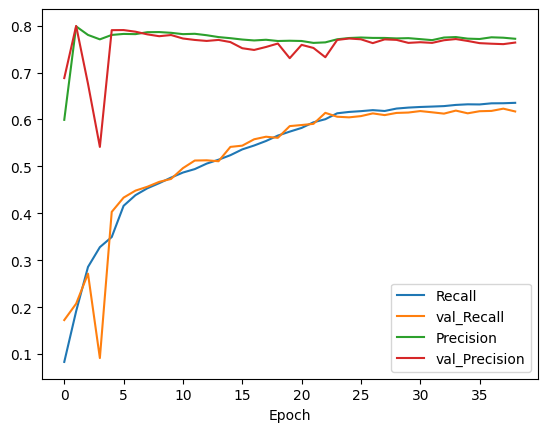

In [ ]:
plt.plot(Best_model.history.history['Recall'])
plt.plot(Best_model.history.history['val_Recall'])
plt.plot(Best_model.history.history['Precision'])
plt.plot(Best_model.history.history['val_Precision'])
plt.legend(("Recall","val_Recall","Precision", "val_Precision"))
plt.xlabel('Epoch')

## Test Scores

In [ ]:
x_test, y_test = hf.generate_validation_data(ecg_filenames, y, test_index)
y_pred = Best_model.predict(x=x_test)
threshold = 0.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

212/212 [==============================] - 207s 974ms/step


In [ ]:
model_report = classification_report(y_test, y_pred_binary, target_names=snomed_classes)
print(model_report)

                                                  precision    recall  f1-score   support

                                   pacing rhythm       0.89      0.77      0.82       177
                             ventricular flutter       1.00      1.00      1.00         1
                           prolonged qt interval       0.33      0.20      0.25        59
                           myocardial infarction       0.54      0.83      0.65        18
                    left ventricular hypertrophy       0.45      0.71      0.55        97
                             atrial fibrillation       0.26      0.35      0.30       267
                                  atrial flutter       0.77      0.49      0.60      1209
                        ventricular fibrillation       1.00      0.89      0.94         9
                        left bundle branch block       0.33      0.36      0.35        36
                                  qwave abnormal       0.51      0.25      0.33       159
         

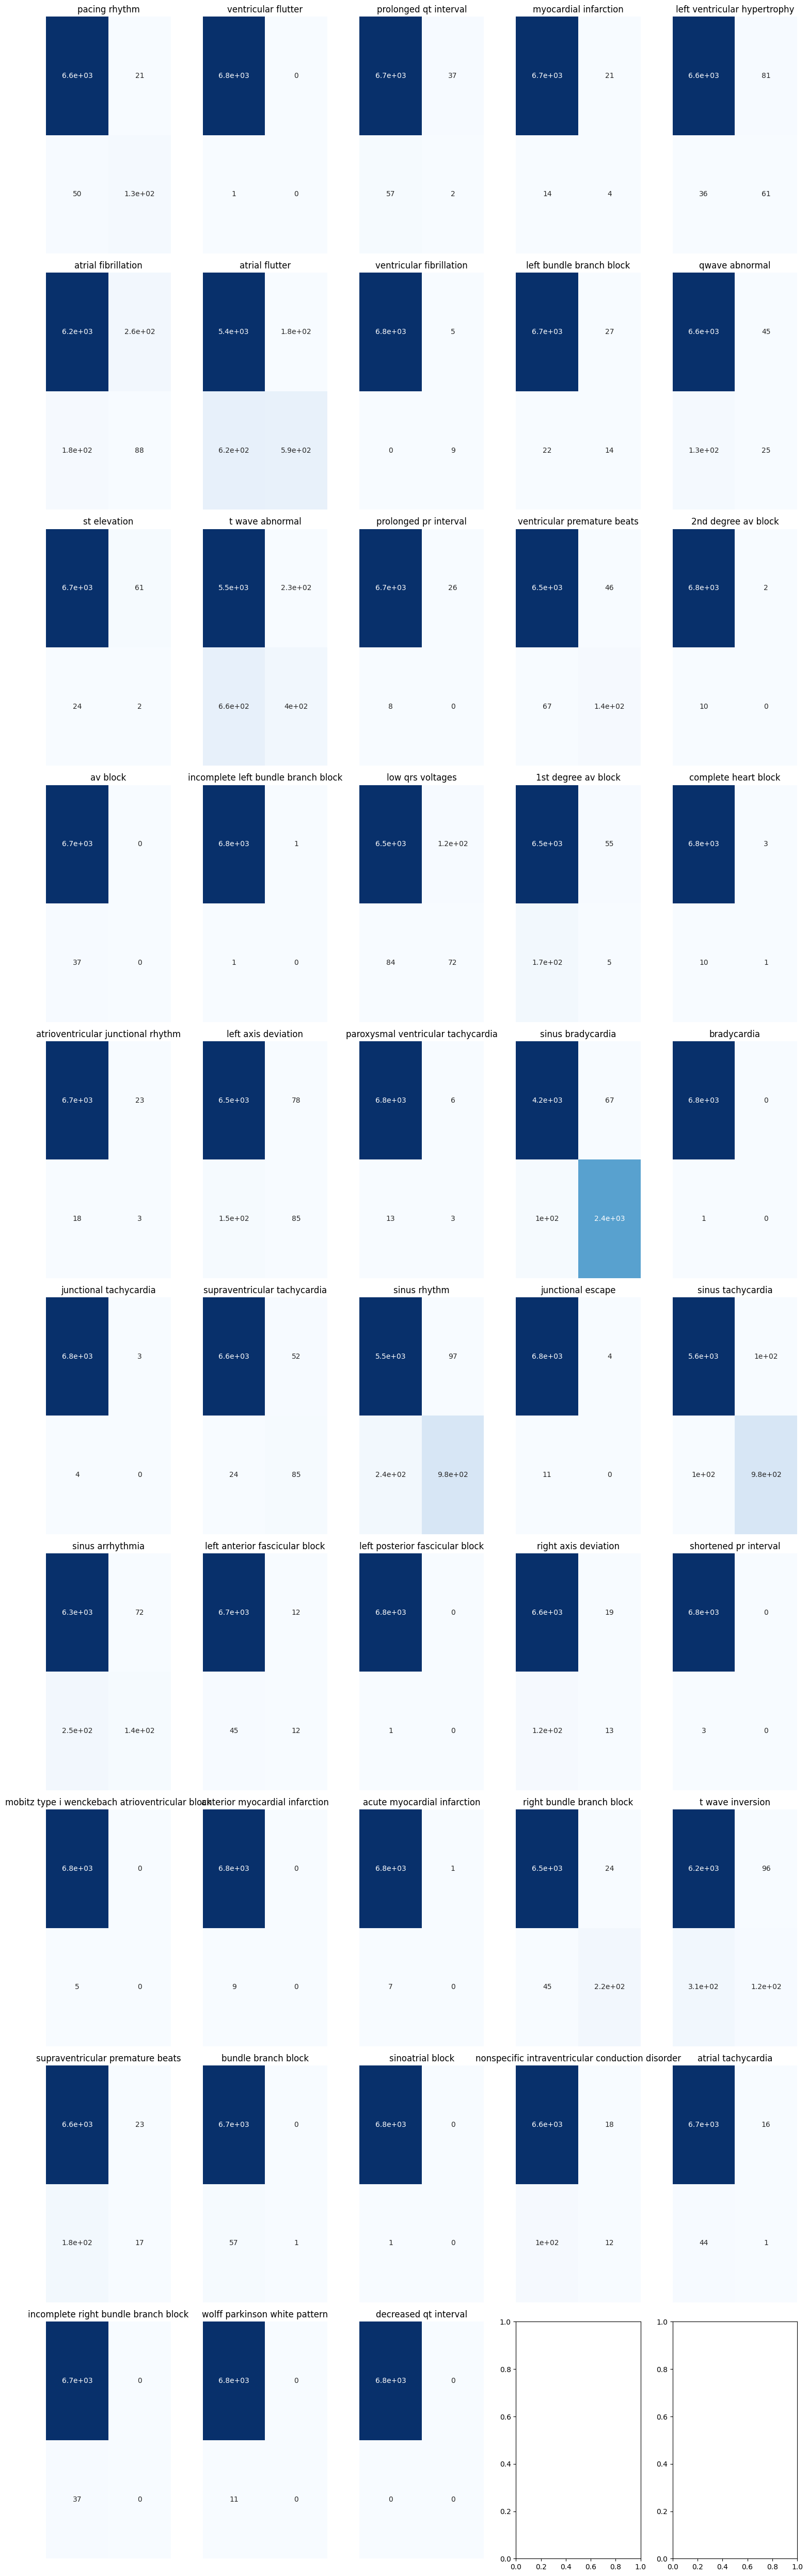

In [ ]:
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=len(snomed_classes))
metric.update_state(y_test, y_pred_binary)
cm = metric.result()
cm.numpy()

fig, axes = plt.subplots(round(len(snomed_classes)/5), 5, figsize=(15, (5*round(len(snomed_classes)/5))))

for i, label in enumerate(snomed_classes):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    # confusion matrix
    sns.heatmap(cm[i], annot=True, cmap='Blues', cbar=False, ax=ax)

    ax.set_title(label)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

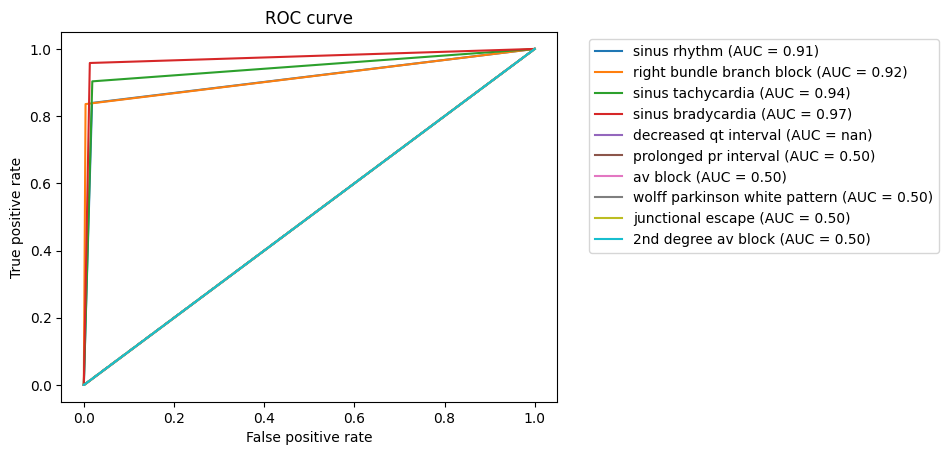

In [ ]:
# Sort AUC values and get indices of top 5 and bottom 5
top_indices = np.argsort(roc_aucTest)[-5:]
bottom_indices = np.argsort(roc_aucTest)[:5]

# Plot the ROC curves for the top 5 and bottom 5 AUC
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line

# Plot top 5 AUC curves
for i in top_indices:
    plt.plot(fpr[i], tpr[i], label=f'{snomed_classes[i]} (AUC = {roc_aucTest[i]:.2f})')

# Plot bottom 5 AUC curves
for i in bottom_indices:
    plt.plot(fpr[i], tpr[i], label=f'{snomed_classes[i]} (AUC = {roc_aucTest[i]:.2f})')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

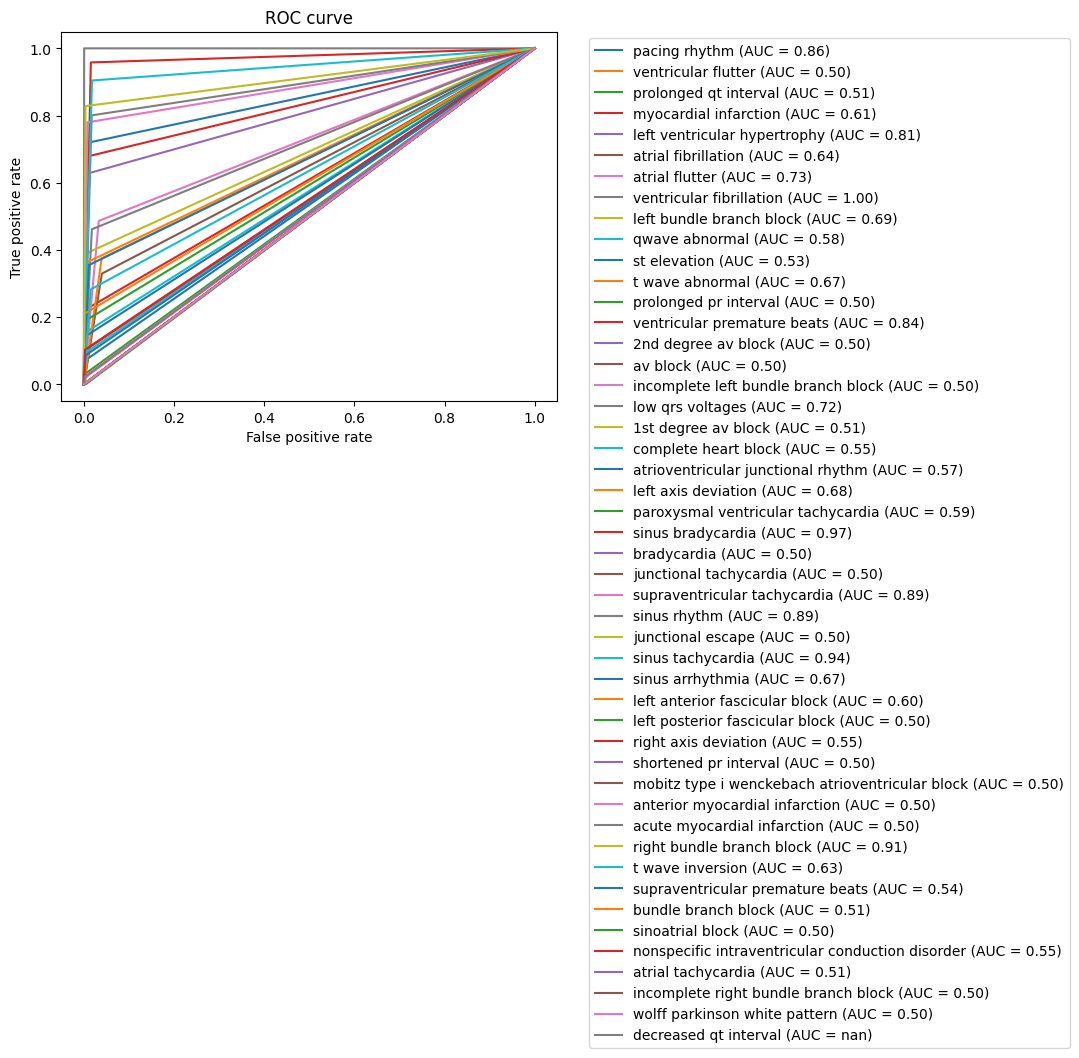

In [ ]:
num_classes = len(snomed_classes)
fpr = [0] * num_classes
tpr = [0] * num_classes
roc_aucTest = [0] * num_classes
label_to_index = {label: index for index, label in enumerate(snomed_classes)}
for label in snomed_classes:
    i = label_to_index[label]
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_aucTest[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for label in snomed_classes:
  i = label_to_index[label]
  plt.plot(fpr[i], tpr[i], label=f'{snomed_classes[i]} (AUC = {roc_aucTest[i]:.2f})')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
num_classes = len(snomed_classes)
fpr = [0] * num_classes
tpr = [0] * num_classes
roc_aucTest = [0] * num_classes
label_to_index = {label: index for index, label in enumerate(snomed_classes)}
for label in snomed_classes:
    i = label_to_index[label]
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_aucTest[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for label in snomed_classes:
  i = label_to_index[label]
  plt.plot(fpr[i], tpr[i], label=f'{snomed_classes[i]} (AUC = {roc_aucTest[i]:.2f})')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Precision Recall curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()